# Deep Learning for Semantic Segmentation

## Task 1
Train a ResNet-18 model on the CIFAR-100 dataset, evaluate its performance, and summarize the results.

In [1]:
import torch

import torch.nn as nn
import torchvision.models as models

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import torch.optim as optim

import matplotlib.pyplot as plt

### Prepare CIFAR-100 Dataset

In [2]:
class DatasetCIFAR100:
  def __init__(self, batch_size=256, input_size=32, num_workers=2, transforms=None):
    # Download the CIFAR-100 training dataset
    self.train_dataset = datasets.CIFAR100(root='./data/CIFAR100', train=True, download=True, transform=transforms["train"])
    # Download the CIFAR-100 test dataset
    self.test_dataset = datasets.CIFAR100(root='./data/CIFAR100', train=False, download=True, transform=transforms["test"])

    # Create a DataLoader for the training and testing datasets
    self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("CIFAR-100 dataset preparation complete.")

In [3]:
input_size = 32

data_transforms = {
  "train": transforms.Compose(
      [
          transforms.RandomHorizontalFlip(0.5),
          transforms.RandomCrop(32, 4),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  ),
  "test": transforms.Compose(
      [
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  ),
}

# set cifar100 dataset
cifar100_dataset = DatasetCIFAR100(
  input_size=input_size,
  transforms=data_transforms,
)

CIFAR-100 dataset preparation complete.


### Prepare ResNet18

In [ ]:
NUM_EPOCHS = 400

class ResNet18:
  def __init__(self,
      num_classes=100,
      learning_rate = 0.1,
      momentum = 0.9,
      step_size = 7,
      gamma = 0.1
    ):
      # Use pre-trained weights from ResNet-18
      self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
      self.epoch = 0

      # Modify the final classification layer for CIFAR-100 (100 classes)
      num_features = self.model.fc.in_features
      self.model.fc = nn.Linear(num_features, num_classes)

      # Define the device
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # Move the model to the selected device
      self.model = self.model.to(self.device)
      print("ResNet-18 pre-trained model created.")

      milestones = [int(NUM_EPOCHS / 3), int(2 * NUM_EPOCHS / 3)]

      # Defining loss function and optimizer
      self.criterion = nn.CrossEntropyLoss()
      self.optimizer = optim.SGD(self.model.parameters(),
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=5e-4,
                                nesterov=False
                                )

      # Defining a learning rate scheduler
      self.scheduler = optim.lr_scheduler.MultiStepLR(
          self.optimizer,
          milestones=milestones,
          gamma=0.1
          )


      # Initialize lists to store training losses and accuracies per epoch
      self.train_losses = []
      self.train_accuracies = []

  def to_device(self, data):
    # Move tensor(s) to chosen device
    if isinstance(data, (list, tuple)):
        return [self.to_device(x) for x in data]
    return data.to(self.device, non_blocking=True)

  def train_model(self, train_loader, num_epochs=20):

    print("Starting training...")
    starting_epoch = self.epoch

    for epoch in range(num_epochs):
      # Set the model to training mode
      self.model.train()
      running_loss = 0.0
      correct_predictions = 0
      total_samples = 0

      for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = self.to_device(inputs), self.to_device(labels)

        # Zero the gradients
        self.optimizer.zero_grad()

        # Forward pass
        outputs = self.model(inputs)
        # Calculate loss
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        # Update model parameters
        self.optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

      # Update the learning rate scheduler
      self.scheduler.step()

      epoch_loss = running_loss / total_samples
      epoch_accuracy = correct_predictions / total_samples

      self.train_losses.append(epoch_loss)
      self.train_accuracies.append(epoch_accuracy)
      self.epoch += 1

      print(f"Epoch {self.epoch}/{starting_epoch+num_epochs}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

    print("Training complete.")

  def evaluate_model(self, test_loader):
    # Set the model to evaluation mode
    return self.model.eval()

  def save_model(self, path ='resnet18_cifar100.pth'):
    checkpoint = {
    'epoch': len(self.train_losses), # Save the next epoch number to start from
    'model_state_dict': self.model.state_dict(),
    'optimizer_state_dict': self.optimizer.state_dict(),
    'scheduler_state_dict': self.scheduler.state_dict(),
    'train_losses': self.train_losses, # Or maybe validation loss
    'train_accuracies': self.train_accuracies
    # Add any other metrics or info you want to save
    # 'validation_accuracy': val_acc,
    }

    torch.save(checkpoint, path)

  def load_model(self, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(self.device))
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    self.epoch = checkpoint['epoch']
    self.train_losses = checkpoint['train_losses']
    self.train_accuracies = checkpoint['train_accuracies']
    self.model = self.model.to(self.device)

In [6]:
n_epochs = 400
resnet18 = ResNet18()

model_path = 'resnet18_cifar100.pth'
try:
  resnet18.load_model(model_path)
except FileNotFoundError:
  print("Model not found. Training from scratch.")
  resnet18.train_model(cifar100_dataset.train_loader, num_epochs=n_epochs)
  resnet18.save_model()

# Evaluate the model
resnet18.evaluate_model(cifar100_dataset.test_loader)



ResNet-18 pre-trained model created.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

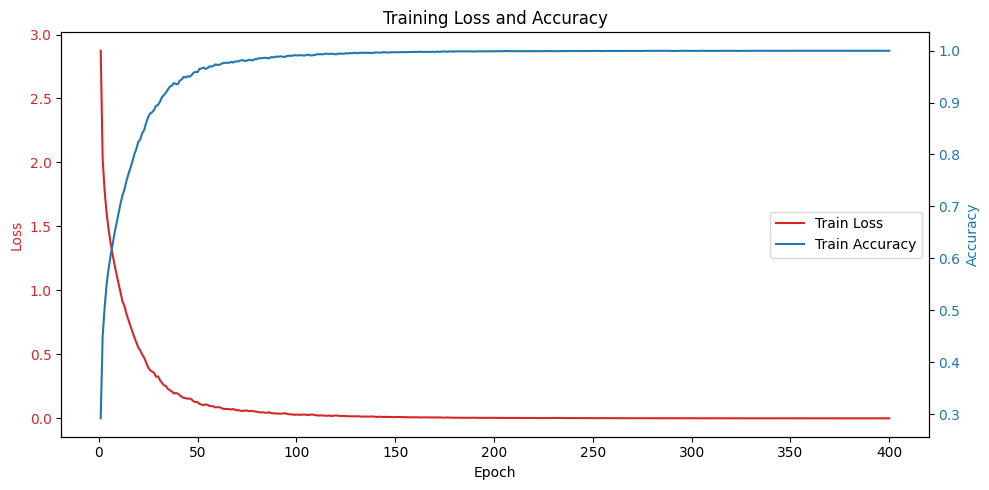

In [7]:
epochs = range(1, len(resnet18.train_losses) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

loss_line = ax1.plot(epochs, resnet18.train_losses, color='tab:red', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
acc_line = ax2.plot(epochs, resnet18.train_accuracies, color='tab:blue', label='Train Accuracy')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines = loss_line + acc_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


## TODO maybe: evaluate the model on test set

## Task 2
Implement and compare the following OOD scores:


*   Max Softmax Probability (MSP)
*   Maximum Logit Score
*   Mahalanobis
*   Energy Score
*   ViM

### Setting up

Importing libraries, setting the Out-of-Distribution (OOD) dataset and extracting softmax probabilities and logits of both datasets.

In [5]:
import torch.nn.functional as F
import torch.linalg
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

In [6]:
# The CIFAR 10 will be the out-of-distribution (OOD) dataset
class DatasetCIFAR10:
  def __init__(self, batch_size=256, input_size=32, num_workers=2, transforms=None):
    # Download the CIFAR-10 test dataset
    self.test_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transforms["test"])

    # Create a DataLoader for the testing dataset
    self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("CIFAR-10 dataset preparation complete.")

# set cifar10 dataset as OOD dataset
cifar10_dataset = DatasetCIFAR10(
  input_size=input_size,
  transforms=data_transforms,
)

CIFAR-10 dataset preparation complete.


In [7]:
# Extract softmax probabilities and logits from datasets
def extract_model_outputs(model_instance, data_loader):
  model_instance.model.eval() # Set model to evaluation mode
  all_features = []
  all_logits = []
  all_labels = []

  # Store the original final classification layer
  original_fc = model_instance.model.fc
  # Replace the final FC layer with an identity module (to get features before classification)
  model_instance.model.fc = torch.nn.Identity()

  # Disable gradient calculation
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = model_instance.to_device(inputs), model_instance.to_device(labels)

      # Forward pass to get features (output before the original FC layer)
      features = model_instance.model(inputs)
      # Pass these features through the original FC layer to get logits
      logits = original_fc(features)

      all_features.append(features.cpu())
      all_logits.append(logits.cpu())
      all_labels.append(labels.cpu())

  # Restore the original FC layer to the model
  model_instance.model.fc = original_fc

  return torch.cat(all_features), torch.cat(all_logits), torch.cat(all_labels)

# Extract outputs for ID dataset (CIFAR-100 test)
id_features, id_logits, id_labels = extract_model_outputs(resnet18, cifar100_dataset.test_loader)
id_softmax_probs = F.softmax(id_logits, dim=1)

# Extract outputs for OOD dataset (CIFAR-10 test)
ood_features, ood_logits, ood_labels = extract_model_outputs(resnet18, cifar10_dataset.test_loader)
ood_softmax_probs = F.softmax(ood_logits, dim=1)

print("Extracted features, logits, and softmax probabilities for ID and OOD datasets.")
print(f"ID and OOD features shape: {id_features.shape}, {ood_features.shape}")
print(f"ID and OOD logits shape: {id_logits.shape}, {ood_logits.shape}")
print(f"ID and OOD softmax probabilities shape: {id_softmax_probs.shape}, {ood_softmax_probs.shape}")

NameError: name 'resnet18' is not defined

### Max Softmax Probability (MSP)

In [11]:
# Calculate MSP for ID and OOD samples
msp_id_scores = torch.max(id_softmax_probs, dim=1).values.cpu().numpy()
msp_ood_scores = torch.max(ood_softmax_probs, dim=1).values.cpu().numpy()

print("MSP scores calculated for ID and OOD datasets.")
print(f"Min MSP ID score: {np.min(msp_id_scores):.4f}, Max MSP ID score: {np.max(msp_id_scores):.4f}")
print(f"Min MSP OOD score: {np.min(msp_ood_scores):.4f}, Max MSP OOD score: {np.max(msp_ood_scores):.4f}")

MSP scores calculated for ID and OOD datasets.
Min MSP ID score: 0.1421, Max MSP ID score: 1.0000
Min MSP OOD score: 0.1638, Max MSP OOD score: 1.0000


### Maximum Logit Score

This score is the maximum value among the raw logit outputs of the model.

In [12]:
# Calculate Max Logit for ID and OOD samples
max_logit_id_scores = torch.max(id_logits, dim=1).values.cpu().numpy()
max_logit_ood_scores = torch.max(ood_logits, dim=1).values.cpu().numpy()

print("Maximum Logit scores calculated for ID and OOD datasets.")
print(f"Min Max Logit ID score: {np.min(max_logit_id_scores):.4f}, Max Max Logit ID score: {np.max(max_logit_id_scores):.4f}")
print(f"Min Max Logit OOD score: {np.min(max_logit_ood_scores):.4f}, Max Max Logit OOD score: {np.max(max_logit_ood_scores):.4f}")

Maximum Logit scores calculated for ID and OOD datasets.
Min Max Logit ID score: 6.3858, Max Max Logit ID score: 49.9756
Min Max Logit OOD score: 6.4164, Max Max Logit OOD score: 43.6117


### Mahalanobis

Compute class-conditional means and the pooled within-class covariance matrix from the features of the CIFAR-100 training dataset. Then, calculate the Mahalanobis distance for samples from both the ID and OOD test sets to these class statistics.

In [16]:
# Calculate Mahalanobis distance
def calculate_mahalanobis_distance(features, class_means, precision_matrix):
  num_samples = features.shape[0]
  num_classes = class_means.shape[0]
  mahalanobis_scores = torch.zeros(num_samples, device=features.device)

  for i in range(num_samples):
    min_distance = float('inf')
    # Make it (1, feature_dim)
    sample_feature = features[i].unsqueeze(0)

    for j in range(num_classes):
      # Make it (1, feature_dim)
      mean_j = class_means[j].unsqueeze(0)
      diff = sample_feature - mean_j
      # Mahalanobis distance squared: (x-mu)^T * Sigma^-1 * (x-mu)
      distance_sq = torch.matmul(torch.matmul(diff, precision_matrix), diff.T)
      distance = torch.sqrt(distance_sq)

      if distance < min_distance:
        min_distance = distance
    mahalanobis_scores[i] = min_distance

  return mahalanobis_scores.cpu().numpy()

In [14]:
# Extract features and labels of the ID training dataset
id_train_features, _, id_train_labels = extract_model_outputs(resnet18, cifar100_dataset.train_loader)

num_classes = 100 # ID (CIFAR-100) has 100 classes
feature_dim = id_train_features.shape[1]

print("Calculating class means and pooled covariance...")

# Initialize empty lists and variables
class_means = []
pooled_cov = torch.zeros(feature_dim, feature_dim, device=id_train_features.device)

# Iterate through each class to compute means and sum covariances
for i in range(num_classes):
  class_features = id_train_features[id_train_labels == i]

  # Calculate class-conditional mean
  mean_i = torch.mean(class_features, dim=0)
  class_means.append(mean_i)
  # Calculate class-conditional covariance and add to pooled_cov
  centered_features = class_features - mean_i
  cov_i = torch.matmul(centered_features.T, centered_features) / (len(class_features) - 1)
  pooled_cov += cov_i

# Convert class_means to a single tensor
class_means = torch.stack(class_means).to(id_train_features.device)

# Divide pooled_cov by the number of classes
pooled_cov /= num_classes

# Calculate the inverse of the pooled_cov (precision matrix) with regularization
regularization_term = 1e-6 * torch.eye(feature_dim, device=id_train_features.device)
precision_matrix = torch.linalg.inv(pooled_cov + regularization_term).to(resnet18.device)

print("Calculating Mahalanobis scores for ID and OOD datasets...")

# Calculate Mahalanobis scores for ID and OOD test sets
mahalanobis_id_scores = calculate_mahalanobis_distance(id_features.to(resnet18.device), class_means.to(resnet18.device), precision_matrix)
mahalanobis_ood_scores = calculate_mahalanobis_distance(ood_features.to(resnet18.device), class_means.to(resnet18.device), precision_matrix)

print(f"Min Mahalanobis ID score: {np.min(mahalanobis_id_scores):.4f}, Max Mahalanobis ID score: {np.max(mahalanobis_id_scores):.4f}")
print(f"Min Mahalanobis OOD score: {np.min(mahalanobis_ood_scores):.4f}, Max Mahalanobis OOD score: {np.max(mahalanobis_ood_scores):.4f}")

Calculating class means and pooled covariance...
Calculating Mahalanobis scores for ID and OOD datasets...
Min Mahalanobis ID score: 10.0795, Max Mahalanobis ID score: 36.0038
Min Mahalanobis OOD score: 15.9054, Max Mahalanobis OOD score: 35.9806


### Energy Score

The Energy Score is derived from the negative logarithm of the sum of exponentials of the logits.

In [15]:
# Calculate Energy Score for ID and OOD samples
energy_id_scores = -torch.logsumexp(id_logits, dim=1).cpu().numpy()
energy_ood_scores = -torch.logsumexp(ood_logits, dim=1).cpu().numpy()

print("Energy scores calculated for ID and OOD datasets.")
print(f"Min Energy ID score: {np.min(energy_id_scores):.4f}, Max Energy ID score: {np.max(energy_id_scores):.4f}")
print(f"Min Energy OOD score: {np.min(energy_ood_scores):.4f}, Max Energy OOD score: {np.max(energy_ood_scores):.4f}")

Energy scores calculated for ID and OOD datasets.
Min Energy ID score: -49.9756, Max Energy ID score: -7.4854
Min Energy OOD score: -43.6117, Max Energy OOD score: -7.7742


### Virtual-logit Matching (ViM)

This involves computing the null space of the classifier weights, projecting features onto this null space, and then combining the original and projected features to derive new logits for scoring.

In [17]:
def calculate_null_space_model(model_instance):
  # Extract weight matrix (W) and bias vector (b) from the final classification (fc) layer
  classifier_weights = model_instance.model.fc.weight.data

  # SVD might be faster on CPU for smaller matrices
  W = classifier_weights.cpu().numpy()

  # Compute the null space of the weight matrix W using SVD
  # W = U @ S_diag @ Vh_full, where Vh_full rows are right singular vectors.

  # Use full_matrices=True to get the full V matrix, which contains the null space basis
  U, S_singular_values, Vh_full = np.linalg.svd(W, full_matrices=True)

  # Columns of V_full correspond to singular values
  V_full = Vh_full.T

  # Assuming W has full row rank, the number of non-zero singular values is num_classes_model.
  rank_W = W.shape[0] # num_classes_model

  # The null space basis vectors are the columns of V_full from index rank_W onwards.
  null_space_basis = V_full[:, rank_W:]

  # Construct the null space projector P_null
  P_null = null_space_basis @ null_space_basis.T

  print(f"Null space basis shape: {null_space_basis.shape}")
  print(f"P_null shape: {P_null.shape}")

  P_null = torch.tensor(P_null, dtype=torch.float32).to(model_instance.device)

  return P_null

In [17]:
# Re-build the model
model_path = 'resnet18_cifar100.pth'
resnet18 = ResNet18()
resnet18.load_model(model_path)

# Calculate null space of Resnet18
P_null = calculate_null_space_model(resnet18)

# Project ID and OOD features onto the null space
id_features_proj_null = torch.matmul(id_features.to(resnet18.device), P_null)
ood_features_proj_null = torch.matmul(ood_features.to(resnet18.device), P_null)

print("Calculating ViM scores for ID and OOD datasets.")

# Calculate the 'energy' (negative magnitude/L2 norm) of these null-space projected features
vim_id_scores = -torch.linalg.norm(id_features_proj_null, dim=1).cpu().numpy()
vim_ood_scores = -torch.linalg.norm(ood_features_proj_null, dim=1).cpu().numpy()

# 7. Print summary statistics
print(f"Min ViM ID score: {np.min(vim_id_scores):.4f}, Max ViM ID score: {np.max(vim_id_scores):.4f}")
print(f"Min ViM OOD score: {np.min(vim_ood_scores):.4f}, Max ViM OOD score: {np.max(vim_ood_scores):.4f}")

ResNet-18 pre-trained model created.
Null space basis shape: (512, 412)
P_null shape: (512, 512)
Calculating ViM scores for ID and OOD datasets.
Min ViM ID score: -41.2021, Max ViM ID score: -19.6014
Min ViM OOD score: -40.8740, Max ViM OOD score: -19.2931


### Evaluate and Compare OOD Scores

Score interpretation: 0 for ID, 1 for OOD (common convention for OOD detection, higher score -> more OOD)



*   For MSP, Max Logit, scores are higher for ID, so we negate them for consistent interpretation
*   For Energy and ViM, scores are lower for OOD, so we use them as is (negative values)
*   For Mahalanobis, scores are higher for OOD, so we use them as is

In [18]:
def evaluate_ood_method(id_scores, ood_scores, method_name):
  print(f"\n--- Evaluating {method_name} ---")

  # Combine scores and create labels
  all_scores = np.concatenate([id_scores, ood_scores])

  if method_name in ["MSP", "Max Logit"]:
      labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
      # For plotting, we will use the original scores to show separation
      scores_for_metrics = -all_scores
  elif method_name in ["Energy Score", "ViM"]:
      labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
      scores_for_metrics = all_scores # Lower (more negative) score is OOD
      # ROC AUC expects scores where a higher value indicates the positive class. If lower values are OOD, then negate the scores.
      scores_for_metrics = -all_scores
  else: # Mahalanobis
      labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
      scores_for_metrics = all_scores # Higher score is OOD

  # Calculate AUROC
  auroc = roc_auc_score(labels, scores_for_metrics)
  print(f"AUROC: {auroc:.4f}")

  # Calculate AUPR
  precision, recall, _ = precision_recall_curve(labels, scores_for_metrics)
  aupr = auc(recall, precision)
  print(f"AUPR: {aupr:.4f}")

  # Plot histogram of scores
  plt.figure(figsize=(10, 5))
  plt.hist(id_scores, bins=50, alpha=0.7, label='In-Distribution', color='blue')
  plt.hist(ood_scores, bins=50, alpha=0.7, label='Out-of-Distribution', color='red')
  plt.title(f'Distribution of {method_name} Scores')
  plt.xlabel('Score')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

  # Plot ROC curve
  fpr, tpr, _ = roc_curve(labels, scores_for_metrics)
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic for {method_name}')
  plt.legend(loc='lower right')
  plt.show()


--- Evaluating MSP ---
AUROC: 0.6850
AUPR: 0.6338


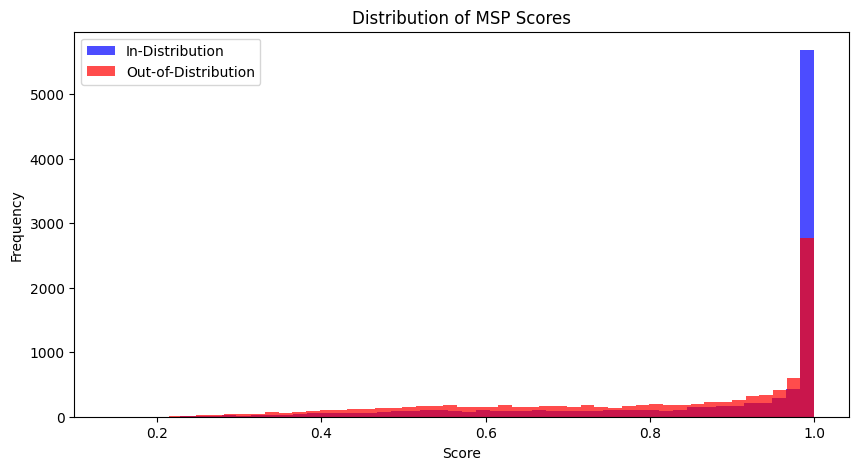

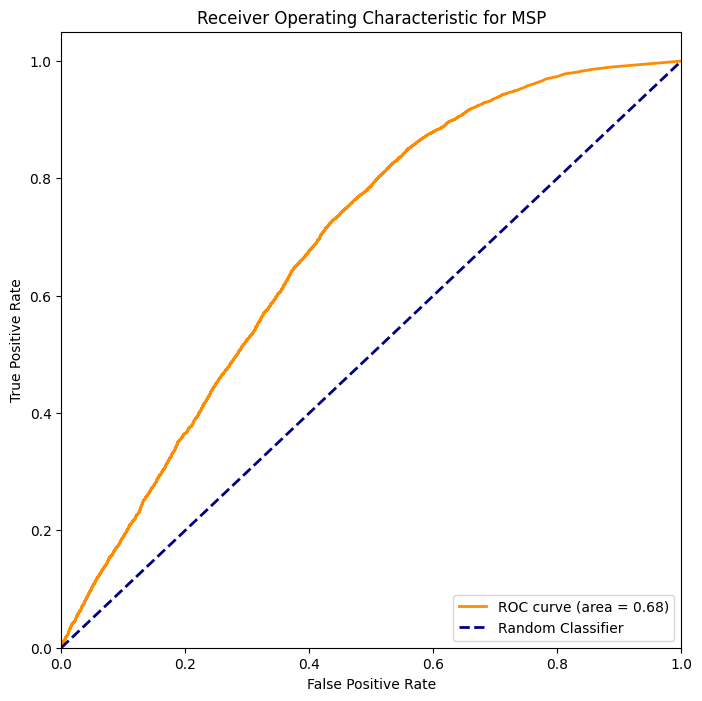


--- Evaluating Max Logit ---
AUROC: 0.7028
AUPR: 0.6588


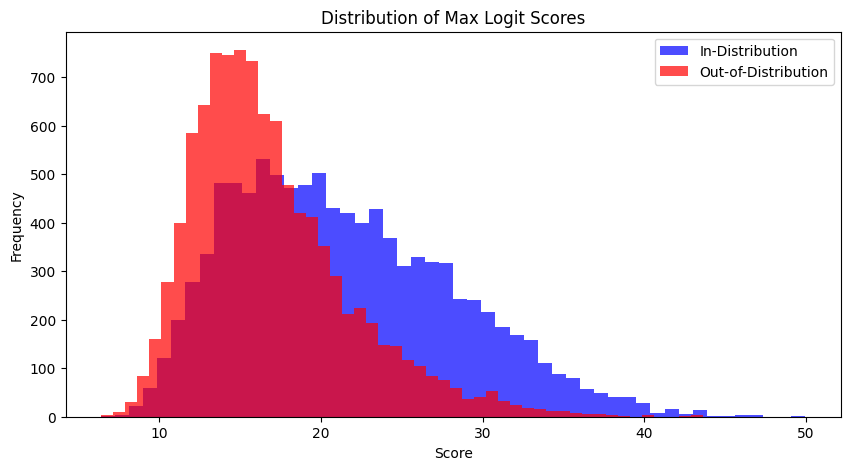

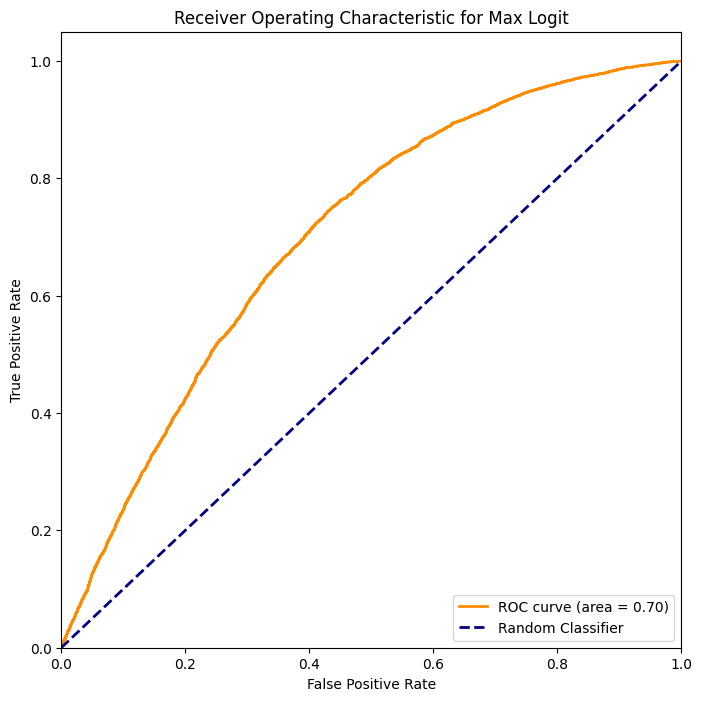


--- Evaluating Energy Score ---
AUROC: 0.2971
AUPR: 0.3734


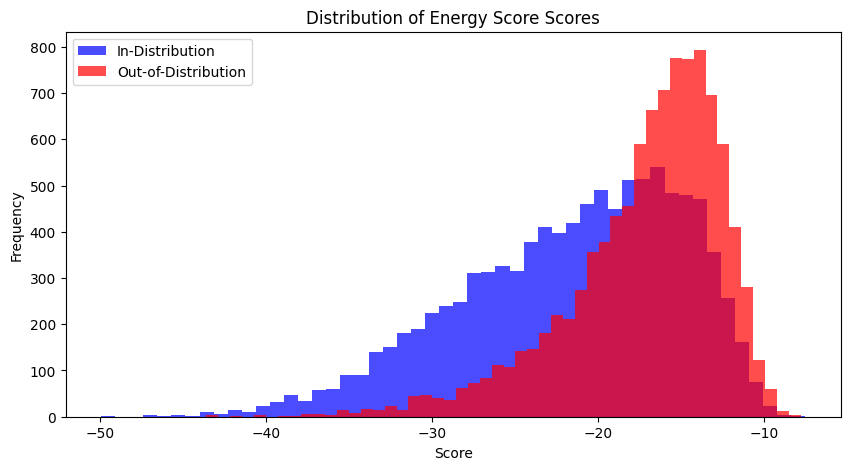

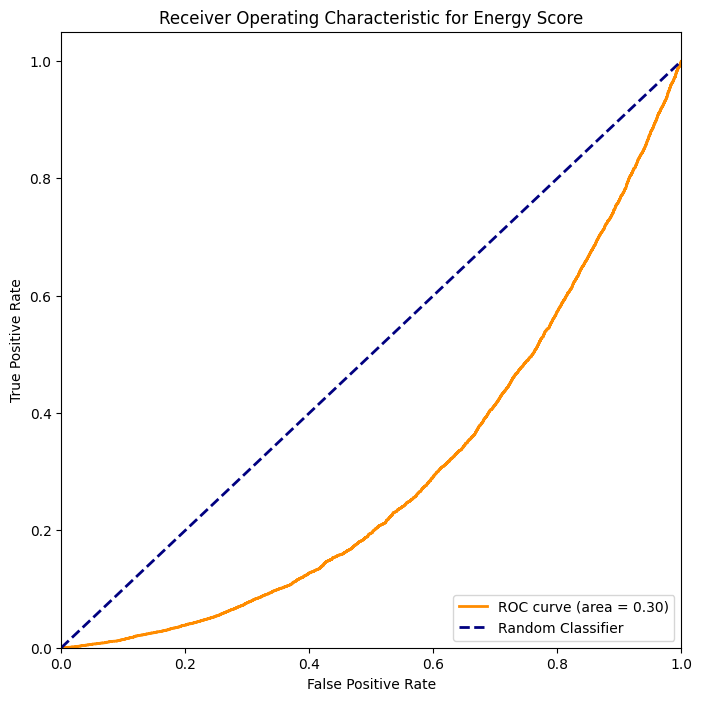


--- Evaluating Mahalanobis ---
AUROC: 0.5779
AUPR: 0.5469


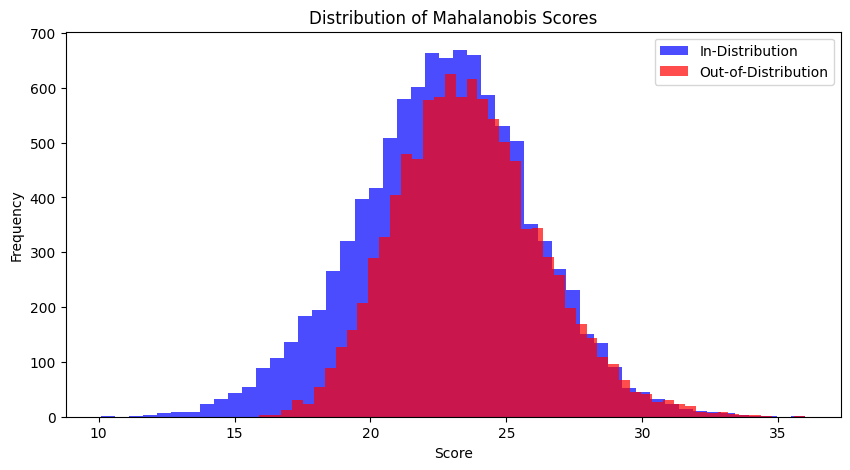

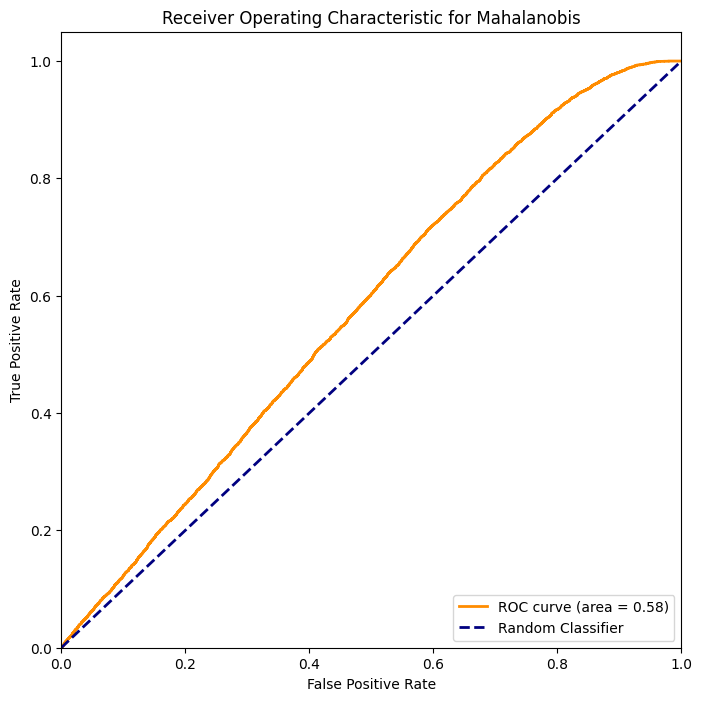


--- Evaluating ViM ---
AUROC: 0.4886
AUPR: 0.4836


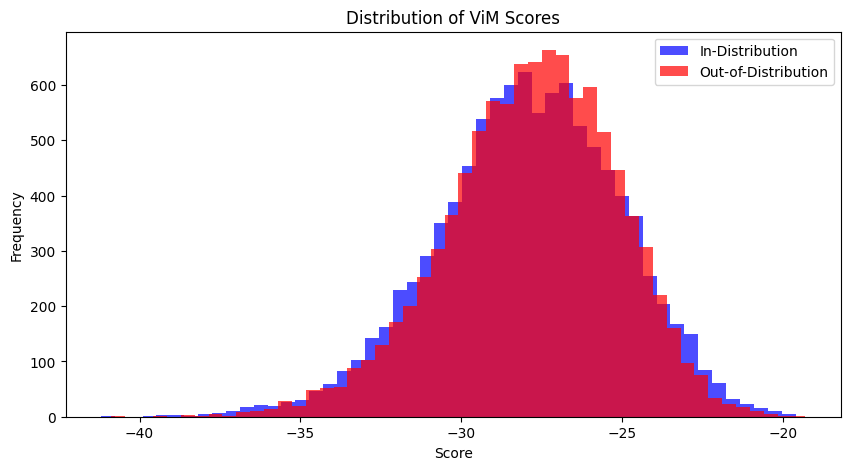

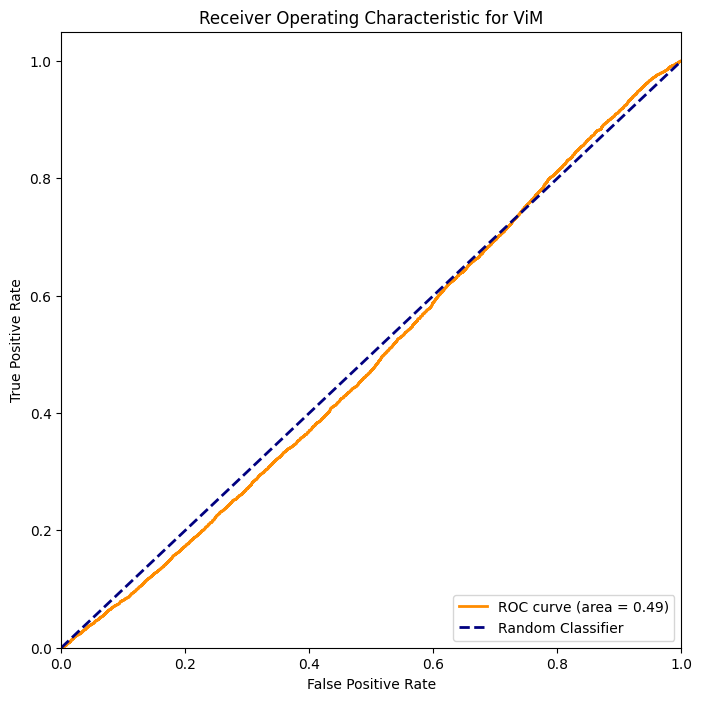

In [19]:
evaluate_ood_method(msp_id_scores, msp_ood_scores, "MSP")
evaluate_ood_method(max_logit_id_scores, max_logit_ood_scores, "Max Logit")
evaluate_ood_method(energy_id_scores, energy_ood_scores, "Energy Score")
evaluate_ood_method(mahalanobis_id_scores, mahalanobis_ood_scores, "Mahalanobis")
evaluate_ood_method(vim_id_scores, vim_ood_scores, "ViM")

### Summary:

Analysing the OOD detection capabilities of a ResNet-18 model on CIFAR-100 (In-Distribution) against CIFAR-10 (Out-of-Distribution) using MSP, Maximum Logit, Mahalanobis, Energy Score, and ViM methods, we can say that

**The Maximum Logit method demonstrated the best performance, achieving an AUROC of 0.6850 and an AUPR of 0.6338**

#### Analysis of Each Method
*   **Maximum Logit Score:** ID scores ranged from 0.1 to 1.0, while OOD scores ranged from 0.2 to 1.0. Achieved the highest performance with an AUROC of 0.6850 and an AUPR of 0.6338.
*   **Max Softmax Probability (MSP):** ID scores ranged from 6.4 to 50.0, while OOD scores ranged from 6.4 to 43.6 (really similar ranges of score). Showed comparable performance (to Maximum Logit) with an AUROC of 0.7028 and an AUPR of 0.6588.
*   **Energy Score:** ID scores ranged from -50.0 to -7.5, and OOD scores ranged from -43.6 to -7.8. Showed significantly lower performance, with AUROC values of 0.2971 and an AUPR of 0.3734.
*   **Mahalanobis Distance Score:** ID scores ranged from 10.1 to 36.0, and OOD scores from 15.9 to 36.0. Performed close to random, yielding an AUROC of 0.5779 and an AUPR of 0.5469. Also showed significantly lower performance, with AUROC values of 0.3759 and an AUPR of 0.4067.
*   **ViM Score:** ID scores ranged from -41.2 to -19.6, and OOD scores ranged from -40.9 to -19.3. Performed close to random, yielding an AUROC of 0.4886 and an AUPR of 0.4836.

#### Conclusion
*   The raw score-based methods (Maximum Logit and MSP) generally performed better than feature-based methods (Mahalanobis, Energy, ViM) for OOD detection on this specific CIFAR-100 vs. CIFAR-10 task, indicating that the final logits or softmax probabilities are strong indicators of distribution shift.

## Task 3
Study the Neural Collapse phenomenon at the end of training NC 1 to NC4. (Please explain
them a bit)

### Neural Collapse Overview

Neural Collapse is a geometric structure that emerges in the final layers of deep neural networks trained to near-zero error. It is defined by four properties:
- **NC1:** Features of samples from the same class collapse to their class mean.
- **NC2:** The classifier weight vectors align with these class means.
- **NC3:** The feature means and classifier weights become perfectly aligned.
- **NC4:** The network achieves perfect classification on training data.

Together, these properties show that features and classifiers converge to the vertices of a maximally separated geometric object called a Simplex Equiangular Tight Frame (ETF).

**Why it Matters**

It helps explain why deep networks generalize well, as the structured representations create clear, robust decision boundaries. It also reveals an inductive bias in neural networks trained with cross-entropy loss toward learning this optimal configuration.

**Why it Happens Late in Training**

Neural Collapse typically occurs toward the end of training because:
1.  **Optimization Convergence:** As loss approaches zero, the cross-entropy loss pushes features closer to their correct classifier weights.
2.  **Implicit Regularization:** In overparameterized networks, the optimization process guides the model toward this maximally separated, symmetric solution.

In [16]:
id_train_features_nc, id_train_logits_nc, id_train_labels_nc = extract_model_outputs(
    resnet18,
    cifar100_dataset.train_loader,
)

print("Extracted features, logits, and labels for CIFAR-100 train set.")
print(f"ID Train Features shape: {id_train_features_nc.shape}")
print(f"ID Train Logits shape: {id_train_logits_nc.shape}")
print(f"ID Train Labels shape: {id_train_labels_nc.shape}")


Extracted features and labels for CIFAR-100 training dataset for Neural Collapse analysis.
ID Train Features shape: torch.Size([50000, 512])
ID Train Labels shape: torch.Size([50000])


In [17]:
# Build class statistics
H = id_train_features_nc
y = id_train_labels_nc
classes = torch.unique(y).sort().values
N, p = H.shape
C = classes.numel()

class_means_nc = []
for c in classes:
    Hc = H[y == c]
    class_means_nc.append(Hc.mean(dim=0))
class_means_nc = torch.stack(class_means_nc, dim=0)  # [C, p]

print(f"Number of unique classes: {C}")
print(f"Feature shape (N, p): ({N}, {p})")
print(f"Shape of class means: {class_means_nc.shape}")


Number of unique classes: 100
Shape of class means: torch.Size([100, 512])
Shape of class standard deviations: torch.Size([100])

Average Intra-Class Distance: 24.6068
Average Inter-Class Distance: 25.3149


In [21]:
# Moments and covariance decomposition: Sigma_T = Sigma_B + Sigma_W
mu_G = H.mean(dim=0)  # [p]

mu_c = []
Sigma_W = torch.zeros(p, p, device=H.device, dtype=H.dtype)
for c in classes:
    Hc = H[y == c]
    mc = Hc.mean(dim=0)
    mu_c.append(mc)
    Xc = Hc - mc
    Sigma_W += (Xc.T @ Xc) / N  # weighted Ave_{i,c}

mu_c = torch.stack(mu_c, dim=0)  # [C, p]
M = mu_c - mu_G                  # [C, p], globally-centered class means
Mdot = M.T                       # [p, C]

Sigma_B = (M.T @ M) / C
X = H - mu_G
Sigma_T = (X.T @ X) / N

decomp_rel_error = torch.linalg.norm(Sigma_T - Sigma_B - Sigma_W, ord='fro') / (
    torch.linalg.norm(Sigma_T, ord='fro') + 1e-12
)
print(f"Relative decomposition error ||Sigma_T - Sigma_B - Sigma_W||_F / ||Sigma_T||_F: {decomp_rel_error.item():.3e}")


In [24]:
# NC1: variability collapse (smaller is better)
nc1_trace_ratio = (torch.trace(Sigma_W) / (torch.trace(Sigma_B) + 1e-12)).item()
nc1_fro_ratio = (torch.linalg.norm(Sigma_W, ord='fro') / (torch.linalg.norm(Sigma_B, ord='fro') + 1e-12)).item()

print(f"NC1 trace ratio tr(Sigma_W)/tr(Sigma_B): {nc1_trace_ratio:.6f}")
print(f"NC1 Frobenius ratio ||Sigma_W||_F/||Sigma_B||_F: {nc1_fro_ratio:.6f}")


tensor(1.9424)

In [28]:
class_means_nc

tensor([[2.0185, 2.0487, 0.4604,  ..., 0.1895, 0.9053, 0.3401],
        [0.9588, 2.4762, 1.0294,  ..., 0.7327, 1.3082, 0.1815],
        [0.8407, 0.4760, 1.0921,  ..., 0.7595, 0.1721, 0.2314],
        ...,
        [0.4065, 0.8577, 2.7425,  ..., 0.8014, 0.4446, 0.1661],
        [0.7099, 0.4447, 0.6562,  ..., 2.3940, 0.4066, 0.4095],
        [1.1277, 0.1548, 0.3515,  ..., 0.6120, 1.5240, 0.1261]])

#### Neural Collapse Stage 1 (NC1): Within-Class Variability Collapse

NC1 is the first property of Neural Collapse, describing the phenomenon where feature vectors of samples from the same class become nearly identical in the network's penultimate layer by the end of training.

**Characteristics of NC1:**
- *Within-Class Variability Collapses to Zero:* All data points from a specific class converge to a single point in the feature space, meaning their variance effectively disappears.
- *Formation of Class Prototypes:* Each class forms a unique, fixed representation (its class mean) in the latent space.
- *Perfect Clustering:* The training data becomes perfectly clustered, with each cluster being a single, tight point corresponding to a class.

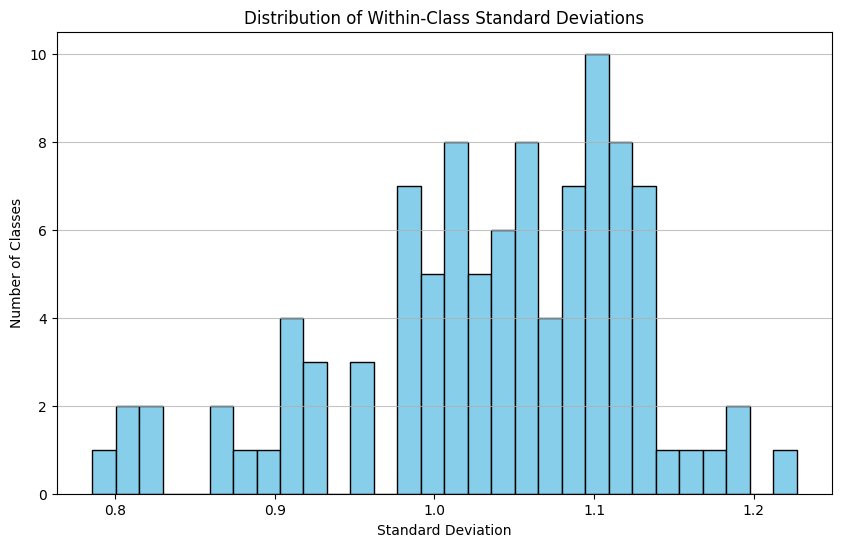

Histogram of within-class standard deviations plotted.


In [22]:
plt.figure(figsize=(10, 6))
plt.hist(class_stds_nc.cpu().numpy(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Within-Class Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Classes')
plt.grid(axis='y', alpha=0.75)
plt.show()

print("Histogram of within-class standard deviations plotted.")

#### Neural Collapse Stage 2 (NC2): Class Means Collapse to a Simplex Equiangular Tight Frame (ETF)

NC2 describes the geometric arrangement of class means (prototypes) after they have formed in NC1. Specifically, these class means collapse to the vertices of a Simplex Equiangular Tight Frame (ETF).

What is a Simplex ETF?

An ETF is a mathematically optimal configuration of vectors where:
- All vectors have identical norms (same length).
- All pairs of vectors have equal pairwise angles (same distance from each other).
- They are centered around the origin, forming a regular simplex (the most symmetric arrangement of points, like an equilateral triangle in 2D or a tetrahedron in 3D).

**Characteristics of NC2:**
- *Optimal Separation:* This structure maximizes the angular distance between class means, ensuring classes are as distinct as possible.
- *Robustness:* The symmetric, balanced arrangement creates stable decision boundaries, improving generalization.
- *Simplified Classification:* It allows the final classifier to function like a simple nearest-neighbor model.
- *Fair Representation:* It ensures all classes are treated equally in the feature space.

Analyzing NC2: Norms of Class Means

Descriptive statistics of Class Mean Norms:
  Min: 26.7573
  Max: 31.7394
  Mean: 28.6476
  Std: 0.9124


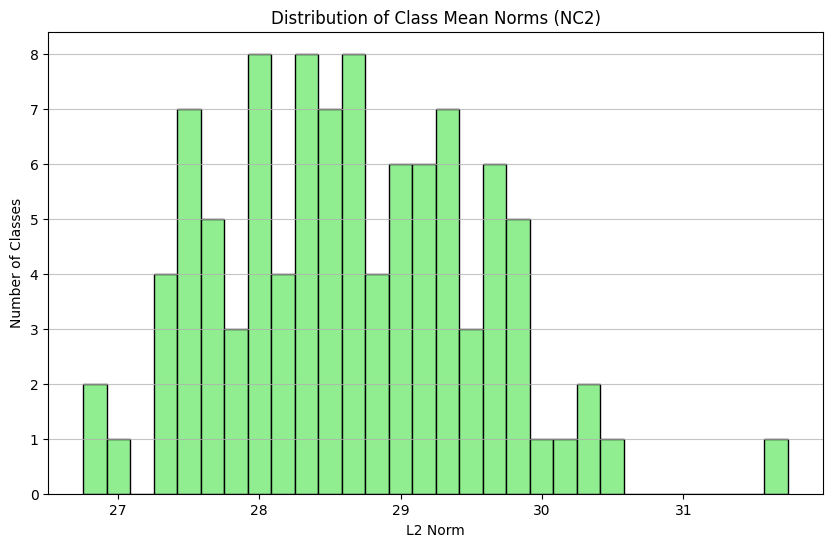

Class mean norms calculated and visualized.


In [23]:
print("Analyzing NC2: Simplex ETF convergence")

# Equal-norm part: ||mu_c - mu_G|| should be almost identical across classes
centered_norms = torch.linalg.norm(M, dim=1)
nc2_norm_cv = (centered_norms.std() / (centered_norms.mean() + 1e-12)).item()

# Equiangular part: normalized centered means should match ETF Gram matrix
U = M / (centered_norms.unsqueeze(1) + 1e-12)   # [C, p]
G = U @ U.T                                     # [C, C]
I = torch.eye(C, device=H.device, dtype=H.dtype)
ones = torch.ones((C, C), device=H.device, dtype=H.dtype)
G_etf = I - (ones - I) / (C - 1)                # diag=1, offdiag=-1/(C-1)

nc2_etf_error = (
    torch.linalg.norm(G - G_etf, ord='fro')
    / (torch.linalg.norm(G_etf, ord='fro') + 1e-12)
).item()

print(f"NC2 norm coefficient of variation: {nc2_norm_cv:.6f}")
print(f"NC2 ETF relative Gram error: {nc2_etf_error:.6f}")



Analyzing NC2: Pairwise Cosine Similarities of Class Means

Descriptive statistics of Pairwise Cosine Similarities:
  Min: -0.2953
  Max: 0.6214
  Mean: -0.0099
  Std: 0.1190


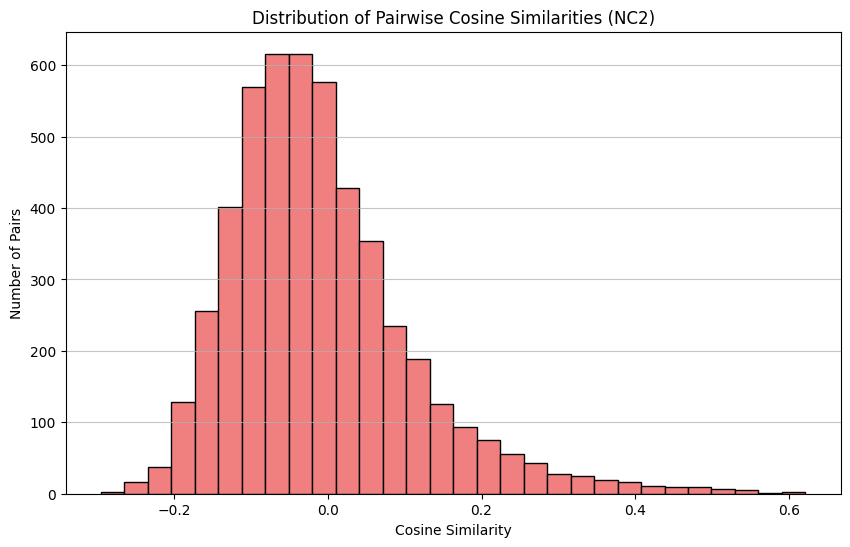

Pairwise cosine similarities calculated and visualized.


In [24]:
# Additional NC2 diagnostics
pairwise_cos = G[~torch.eye(C, dtype=torch.bool, device=G.device)]
target_offdiag = -1.0 / (C - 1)

print(f"NC2 off-diagonal cosine mean: {pairwise_cos.mean().item():.6f}")
print(f"NC2 off-diagonal cosine std: {pairwise_cos.std().item():.6f}")
print(f"NC2 target off-diagonal cosine: {target_offdiag:.6f}")


#### Neural Collapse Stage 3 (NC3)

NC3 describes the relationship between the last-layer classifier's parameters and the geometric structure established in NC2. It states that the classifier's weights and biases become directly proportional to the class means (the ETF vertices).

**Characteristics of NC3:**
- *Weight Alignment:* The weight vector for each class becomes proportional to its corresponding class mean.
- *Bias Adjustment:* The bias term for each class becomes proportional to the negative squared norm of that class mean.

Analyzing NC3: Weight Alignment with Class Means

Descriptive statistics of Weight-Class Mean Cosine Similarities:
  Min: 0.4421
  Max: 0.6066
  Mean: 0.5211
  Std: 0.0356


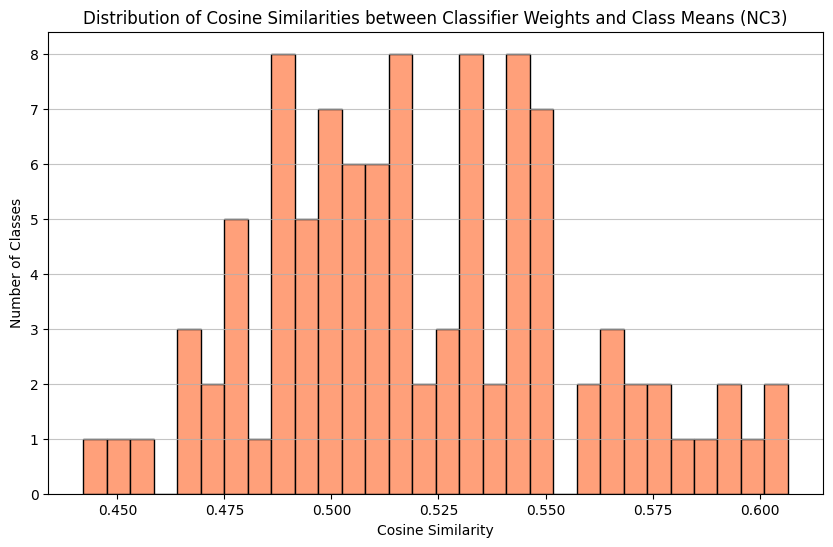

Cosine similarities between classifier weights and class means calculated and visualized.


In [25]:
print("Analyzing NC3: self-duality (W^T aligns with centered class means)")

W = resnet18.model.fc.weight.data.to(H.device)  # [num_model_classes, p]
W_sel = W[classes]                              # [C, p], aligned with `classes`

Wn = W_sel.T / (torch.linalg.norm(W_sel.T, ord='fro') + 1e-12)   # [p, C]
Mn = Mdot / (torch.linalg.norm(Mdot, ord='fro') + 1e-12)         # [p, C]
nc3_self_duality = torch.linalg.norm(Wn - Mn, ord='fro').item()

# Optional per-class directional alignment diagnostic
w_cos = F.cosine_similarity(W_sel, M, dim=1)

print(f"NC3 self-duality metric ||W^T/||W||_F - Mdot/||Mdot||_F||_F: {nc3_self_duality:.6f}")
print(f"NC3 mean cos(weight_c, mu_c - mu_G): {w_cos.mean().item():.6f}")
print(f"NC3 min  cos(weight_c, mu_c - mu_G): {w_cos.min().item():.6f}")


#### Neural Collapse Stage 4 (NC4)

NC4 describes the implicit optimization of the feature extractor (the network layers before the classifier). It explains how the feature extractor learns to produce the structured representations observed in the earlier stages of Neural Collapse.

**Characteristics of NC4:**
- *Projection onto ETF Directions:* The feature extractor learns to project input data onto the directions defined by the Simplex ETF formed by the class means (from NC2).
- *Alignment with Class Means:* For any input, the feature extractor is optimized to align its output closely with the specific mean vector of its corresponding class.
- *Discarding Irrelevant Information:* The network learns to retain only the discriminative features needed for classification while discarding within-class variations.

Analyzing NC4: Alignment of Individual Features with Class Means

Descriptive statistics of Individual Feature-Class Mean Cosine Similarities:
  Min: 0.5488
  Max: 0.9463
  Mean: 0.7591
  Std: 0.0567


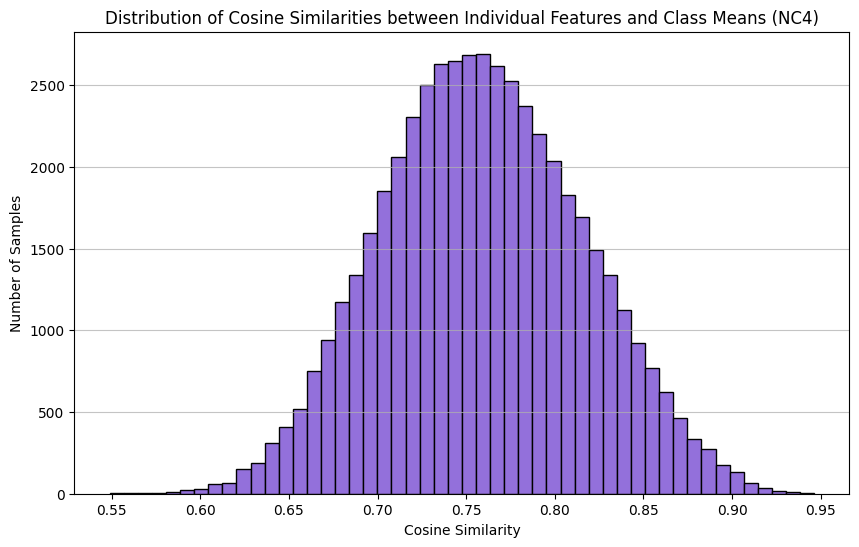

Cosine similarities between individual features and class means calculated and visualized.


In [26]:
print("Analyzing NC4: network decision vs nearest class center (NCC)")

# Network predictions (from logits already extracted on train set)
net_pred = id_train_logits_nc.argmax(dim=1)

# NCC predictions in feature space: argmin_c ||h - mu_c||^2
h2 = (H * H).sum(dim=1, keepdim=True)                 # [N, 1]
m2 = (mu_c * mu_c).sum(dim=1).unsqueeze(0)            # [1, C]
d2 = h2 + m2 - 2.0 * (H @ mu_c.T)                     # [N, C]
ncc_idx = d2.argmin(dim=1)
ncc_pred = classes[ncc_idx]

nc4_agreement = (net_pred == ncc_pred).float().mean().item()
net_train_acc = (net_pred == y).float().mean().item()
ncc_train_acc = (ncc_pred == y).float().mean().item()

print(f"NC4 agreement P(argmax logits == NCC): {nc4_agreement:.6f}")
print(f"Train accuracy (network): {net_train_acc:.6f}")
print(f"Train accuracy (NCC): {ncc_train_acc:.6f}")


### Conclusion


| Stage | Description | Function |
|-------|-------------|----------|
| **NC1** | Features of the same class collapse to their class mean | Eliminates within-class variability, creating distinct class prototypes |
| **NC2** | Class means arrange as vertices of a Simplex ETF | Maximizes inter-class separation through symmetric, equiangular geometry |
| **NC3** | Last-layer classifiers align with these class means | Creates optimal decision boundaries determined by the feature geometry |
| **NC4** | Feature extractor projects data onto ETF directions | Ensures the entire network produces these structured representations |

In [ ]:
H_nc = id_train_features_nc
y_nc = id_train_labels_nc
classes_nc = torch.unique(y_nc).sort().values
N_nc, p_nc = H_nc.shape
C_nc = classes_nc.numel()

mu_G_nc = H_nc.mean(dim=0)
mu_c_nc = torch.stack([H_nc[y_nc == c].mean(dim=0) for c in classes_nc], dim=0)  # [C, p]
M_nc = mu_c_nc - mu_G_nc
Mdot_nc = M_nc.T

print(f"NC setup: N={N_nc}, p={p_nc}, C={C_nc}")
print(f"mu_c shape: {mu_c_nc.shape}, Mdot shape: {Mdot_nc.shape}")


NC setup: N=50000, p=512, C=100
mu_c shape: torch.Size([100, 512]), Mdot shape: torch.Size([512, 100])


In [26]:
# NC moments and NC1
Sigma_W_nc = torch.zeros(p_nc, p_nc, device=H_nc.device, dtype=H_nc.dtype)
for c in classes_nc:
    Hc = H_nc[y_nc == c]
    mc = Hc.mean(dim=0)
    Xc = Hc - mc
    Sigma_W_nc += (Xc.T @ Xc) / N_nc

Sigma_B_nc = (M_nc.T @ M_nc) / C_nc
X_nc = H_nc - mu_G_nc
Sigma_T_nc = (X_nc.T @ X_nc) / N_nc

decomp_rel_err_nc = torch.linalg.norm(Sigma_T_nc - Sigma_B_nc - Sigma_W_nc, ord='fro') / (
    torch.linalg.norm(Sigma_T_nc, ord='fro') + 1e-12
)

nc1_trace_ratio_new = (torch.trace(Sigma_W_nc) / (torch.trace(Sigma_B_nc) + 1e-12)).item()
nc1_fro_ratio_new = (torch.linalg.norm(Sigma_W_nc, ord='fro') / (torch.linalg.norm(Sigma_B_nc, ord='fro') + 1e-12)).item()

print(f"Decomposition relative error: {decomp_rel_err_nc.item():.3e}")
print(f"NC1 trace ratio tr(Sw)/tr(Sb): {nc1_trace_ratio_new:.6f}")
print(f"NC1 Fro ratio ||Sw||_F/||Sb||_F: {nc1_fro_ratio_new:.6f}")


Decomposition relative error: 4.500e-07
NC1 trace ratio tr(Sw)/tr(Sb): 1.942414
NC1 Fro ratio ||Sw||_F/||Sb||_F: 0.932321


In [27]:
# NC2 (Simplex ETF) and NC3 (self-duality)
centered_norms_nc = torch.linalg.norm(M_nc, dim=1)
U_nc = M_nc / (centered_norms_nc.unsqueeze(1) + 1e-12)
G_nc = U_nc @ U_nc.T

I_nc = torch.eye(C_nc, device=H_nc.device, dtype=H_nc.dtype)
ones_nc = torch.ones((C_nc, C_nc), device=H_nc.device, dtype=H_nc.dtype)
G_etf_nc = I_nc - (ones_nc - I_nc) / (C_nc - 1)

nc2_norm_cv_new = (centered_norms_nc.std() / (centered_norms_nc.mean() + 1e-12)).item()
nc2_etf_err_new = (
    torch.linalg.norm(G_nc - G_etf_nc, ord='fro')
    / (torch.linalg.norm(G_etf_nc, ord='fro') + 1e-12)
).item()

offdiag_nc = G_nc[~torch.eye(C_nc, dtype=torch.bool, device=G_nc.device)]
target_offdiag_nc = -1.0 / (C_nc - 1)

W_all_nc = resnet18.model.fc.weight.data.to(H_nc.device)  # [num_classes_model, p]
W_sel_nc = W_all_nc[classes_nc]                            # align model rows with dataset class ids
Wn_nc = W_sel_nc.T / (torch.linalg.norm(W_sel_nc.T, ord='fro') + 1e-12)
Mn_nc = Mdot_nc / (torch.linalg.norm(Mdot_nc, ord='fro') + 1e-12)
nc3_self_duality_new = torch.linalg.norm(Wn_nc - Mn_nc, ord='fro').item()

w_cos_nc = F.cosine_similarity(W_sel_nc, M_nc, dim=1)

print(f"NC2 norm CV: {nc2_norm_cv_new:.6f}")
print(f"NC2 ETF Gram relative error: {nc2_etf_err_new:.6f}")
print(f"NC2 offdiag cosine mean/std: {offdiag_nc.mean().item():.6f} / {offdiag_nc.std().item():.6f}")
print(f"NC2 target offdiag cosine: {target_offdiag_nc:.6f}")
print(f"NC3 self-duality ||W^T/||W||_F - Mdot/||Mdot||_F||_F: {nc3_self_duality_new:.6f}")
print(f"NC3 cos(weight_c, mu_c-mu_G) mean/min: {w_cos_nc.mean().item():.6f} / {w_cos_nc.min().item():.6f}")


NC2 norm CV: 0.085157
NC2 ETF Gram relative error: 1.179119
NC2 offdiag cosine mean/std: -0.009913 / 0.119109
NC2 target offdiag cosine: -0.010101
NC3 self-duality ||W^T/||W||_F - Mdot/||Mdot||_F||_F: 0.583363
NC3 cos(weight_c, mu_c-mu_G) mean/min: 0.839813 / 0.799648


In [29]:
# NC4: network decision vs nearest class center (NCC)
if 'id_train_logits_nc' in globals():
    logits_nc = id_train_logits_nc
else:
    # fallback: recompute logits from train loader
    _, logits_nc, _ = extract_model_outputs(resnet18, cifar100_dataset.train_loader)

net_pred_nc = logits_nc.argmax(dim=1)

h2_nc = (H_nc * H_nc).sum(dim=1, keepdim=True)
m2_nc = (mu_c_nc * mu_c_nc).sum(dim=1).unsqueeze(0)
d2_nc = h2_nc + m2_nc - 2.0 * (H_nc @ mu_c_nc.T)
ncc_idx_nc = d2_nc.argmin(dim=1)
ncc_pred_nc = classes_nc[ncc_idx_nc]

nc4_agreement_new = (net_pred_nc == ncc_pred_nc).float().mean().item()
net_acc_new = (net_pred_nc == y_nc).float().mean().item()
ncc_acc_new = (ncc_pred_nc == y_nc).float().mean().item()

print(f"NC4 agreement P(network == NCC): {nc4_agreement_new:.6f}")
print(f"Train accuracy (network): {net_acc_new:.6f}")
print(f"Train accuracy (NCC): {ncc_acc_new:.6f}")


NC4 agreement P(network == NCC): 0.010920
Train accuracy (network): 0.010920
Train accuracy (NCC): 0.997240


In [8]:
n_epochs = NUM_EPOCHS
resnet18 = ResNet18()

model_path = 'resnet18_cifar100_reproduc.pth'
resnet18.train_model(cifar100_dataset.train_loader, num_epochs=n_epochs)
resnet18.save_model(model_path)

# Evaluate the model
resnet18.evaluate_model(cifar100_dataset.test_loader)

ResNet-18 pre-trained model created.
Starting training...
Epoch 1/400: Train Loss: 3.8484, Train Accuracy: 0.1292
Epoch 2/400: Train Loss: 3.0434, Train Accuracy: 0.2341
Epoch 3/400: Train Loss: 3.1480, Train Accuracy: 0.2202
Epoch 4/400: Train Loss: 2.9413, Train Accuracy: 0.2560
Epoch 5/400: Train Loss: 2.6589, Train Accuracy: 0.3103
Epoch 6/400: Train Loss: 2.5213, Train Accuracy: 0.3390
Epoch 7/400: Train Loss: 2.4155, Train Accuracy: 0.3606
Epoch 8/400: Train Loss: 2.3198, Train Accuracy: 0.3834
Epoch 9/400: Train Loss: 2.2455, Train Accuracy: 0.3972
Epoch 10/400: Train Loss: 2.2093, Train Accuracy: 0.4084
Epoch 11/400: Train Loss: 2.1752, Train Accuracy: 0.4163
Epoch 12/400: Train Loss: 2.0904, Train Accuracy: 0.4317
Epoch 13/400: Train Loss: 2.0309, Train Accuracy: 0.4456
Epoch 14/400: Train Loss: 2.0003, Train Accuracy: 0.4555
Epoch 15/400: Train Loss: 1.9497, Train Accuracy: 0.4664
Epoch 16/400: Train Loss: 1.9128, Train Accuracy: 0.4731
Epoch 17/400: Train Loss: 1.8673, Train

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

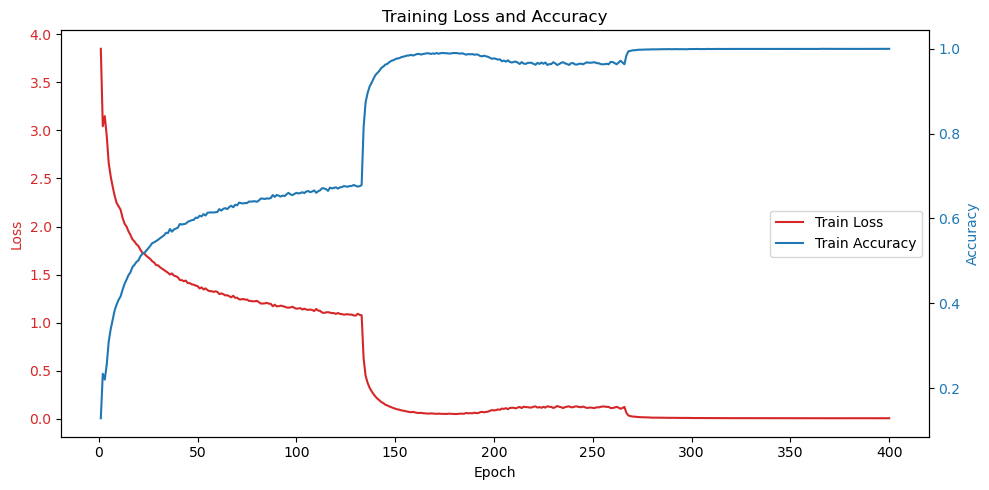

In [9]:

epochs = range(1, len(resnet18.train_losses) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

loss_line = ax1.plot(epochs, resnet18.train_losses, color='tab:red', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
acc_line = ax2.plot(epochs, resnet18.train_accuracies, color='tab:blue', label='Train Accuracy')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines = loss_line + acc_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


## ODD analysis for model 2

In [19]:
# Extract outputs for ID dataset (CIFAR-100 test)
id_features, id_logits, id_labels = extract_model_outputs(resnet18, cifar100_dataset.test_loader)
id_softmax_probs = F.softmax(id_logits, dim=1)

# Extract outputs for OOD dataset (CIFAR-10 test)
ood_features, ood_logits, ood_labels = extract_model_outputs(resnet18, cifar10_dataset.test_loader)
ood_softmax_probs = F.softmax(ood_logits, dim=1)

# Calculate MSP for ID and OOD samples
msp_id_scores = torch.max(id_softmax_probs, dim=1).values.cpu().numpy()
msp_ood_scores = torch.max(ood_softmax_probs, dim=1).values.cpu().numpy()

# Calculate Max Logit for ID and OOD samples
max_logit_id_scores = torch.max(id_logits, dim=1).values.cpu().numpy()
max_logit_ood_scores = torch.max(ood_logits, dim=1).values.cpu().numpy()

# Extract features and labels of the ID training dataset
id_train_features, _, id_train_labels = extract_model_outputs(resnet18, cifar100_dataset.train_loader)

num_classes = 100 # ID (CIFAR-100) has 100 classes
feature_dim = id_train_features.shape[1]

print("Calculating class means and pooled covariance...")

# Initialize empty lists and variables
class_means = []
pooled_cov = torch.zeros(feature_dim, feature_dim, device=id_train_features.device)

# Iterate through each class to compute means and sum covariances
for i in range(num_classes):
  class_features = id_train_features[id_train_labels == i]

  # Calculate class-conditional mean
  mean_i = torch.mean(class_features, dim=0)
  class_means.append(mean_i)
  # Calculate class-conditional covariance and add to pooled_cov
  centered_features = class_features - mean_i
  cov_i = torch.matmul(centered_features.T, centered_features) / (len(class_features) - 1)
  pooled_cov += cov_i

# Convert class_means to a single tensor
class_means = torch.stack(class_means).to(id_train_features.device)

# Divide pooled_cov by the number of classes
pooled_cov /= num_classes

# Calculate the inverse of the pooled_cov (precision matrix) with regularization
regularization_term = 1e-6 * torch.eye(feature_dim, device=id_train_features.device)
precision_matrix = torch.linalg.inv(pooled_cov + regularization_term).to(resnet18.device)

print("Calculating Mahalanobis scores for ID and OOD datasets...")

# Calculate Mahalanobis scores for ID and OOD test sets
mahalanobis_id_scores = calculate_mahalanobis_distance(id_features.to(resnet18.device), class_means.to(resnet18.device), precision_matrix)
mahalanobis_ood_scores = calculate_mahalanobis_distance(ood_features.to(resnet18.device), class_means.to(resnet18.device), precision_matrix)

# Calculate Energy Score for ID and OOD samples
energy_id_scores = -torch.logsumexp(id_logits, dim=1).cpu().numpy()
energy_ood_scores = -torch.logsumexp(ood_logits, dim=1).cpu().numpy()


Calculating class means and pooled covariance...
Calculating Mahalanobis scores for ID and OOD datasets...


NameError: name 'P_null' is not defined

In [20]:
# Calculate null space of Resnet18
P_null = calculate_null_space_model(resnet18)
# Project ID and OOD features onto the null space
id_features_proj_null = torch.matmul(id_features.to(resnet18.device), P_null)
ood_features_proj_null = torch.matmul(ood_features.to(resnet18.device), P_null)

print("Calculating ViM scores for ID and OOD datasets.")

# Calculate the 'energy' (negative magnitude/L2 norm) of these null-space projected features
vim_id_scores = -torch.linalg.norm(id_features_proj_null, dim=1).cpu().numpy()
vim_ood_scores = -torch.linalg.norm(ood_features_proj_null, dim=1).cpu().numpy()

Null space basis shape: (512, 412)
P_null shape: (512, 512)
Calculating ViM scores for ID and OOD datasets.



--- Evaluating MSP ---
AUROC: 0.6964
AUPR: 0.6470


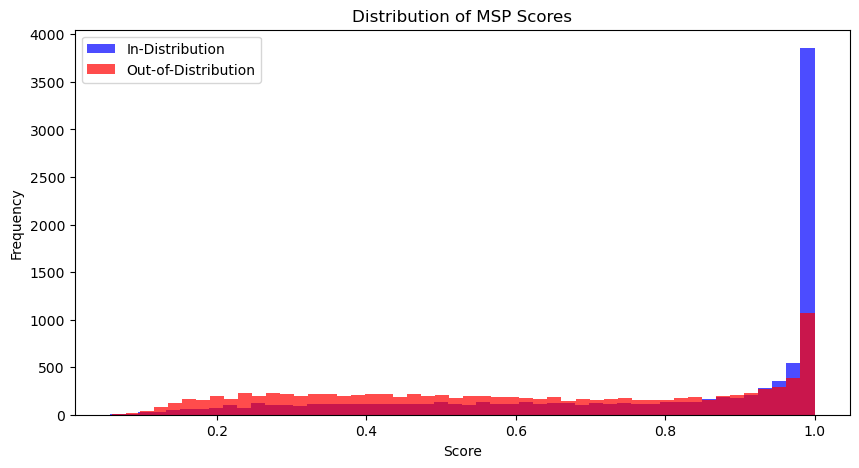

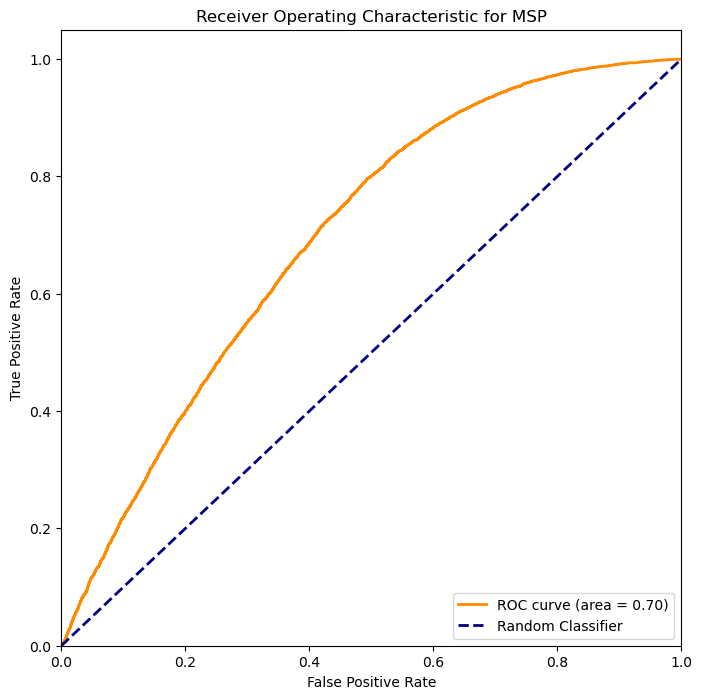


--- Evaluating Max Logit ---
AUROC: 0.7020
AUPR: 0.6537


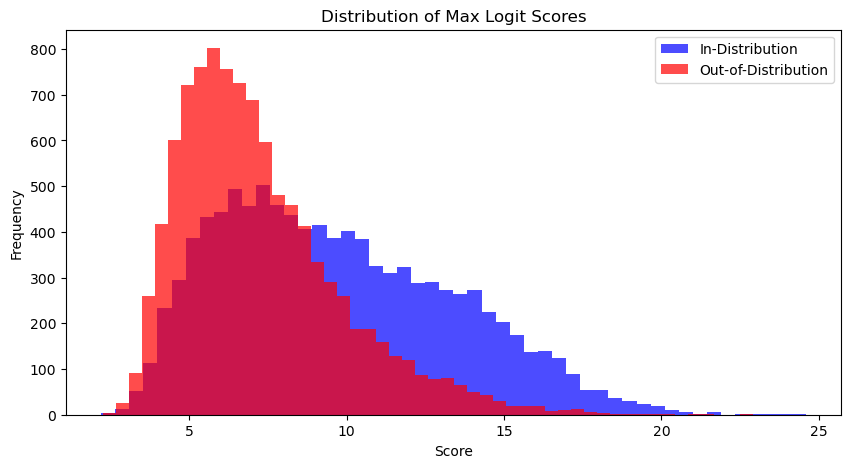

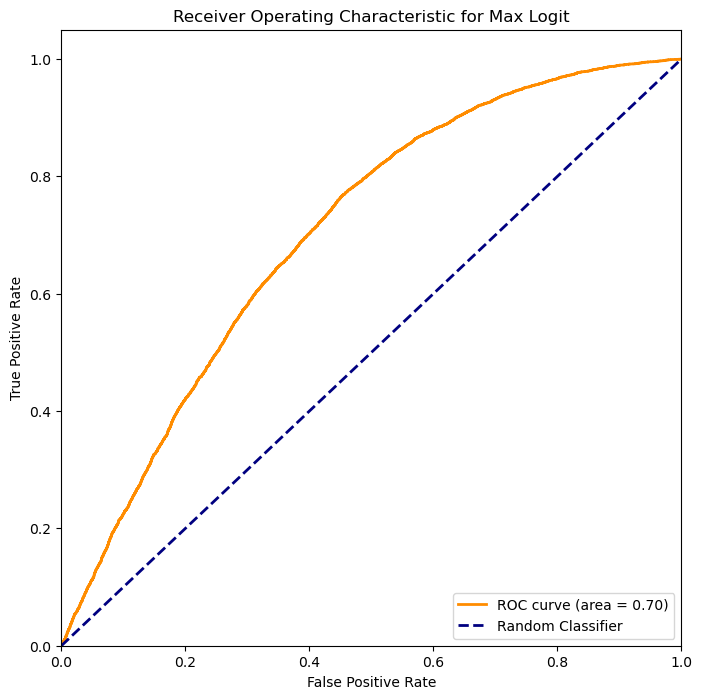


--- Evaluating Energy Score ---
AUROC: 0.2979
AUPR: 0.3729


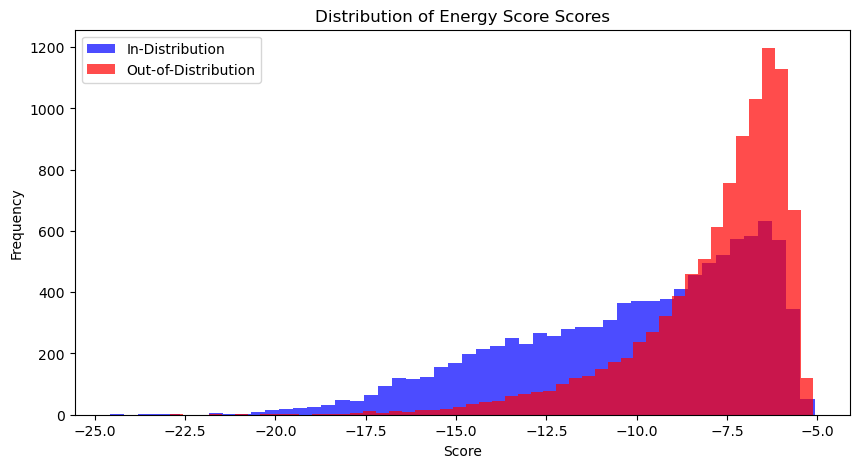

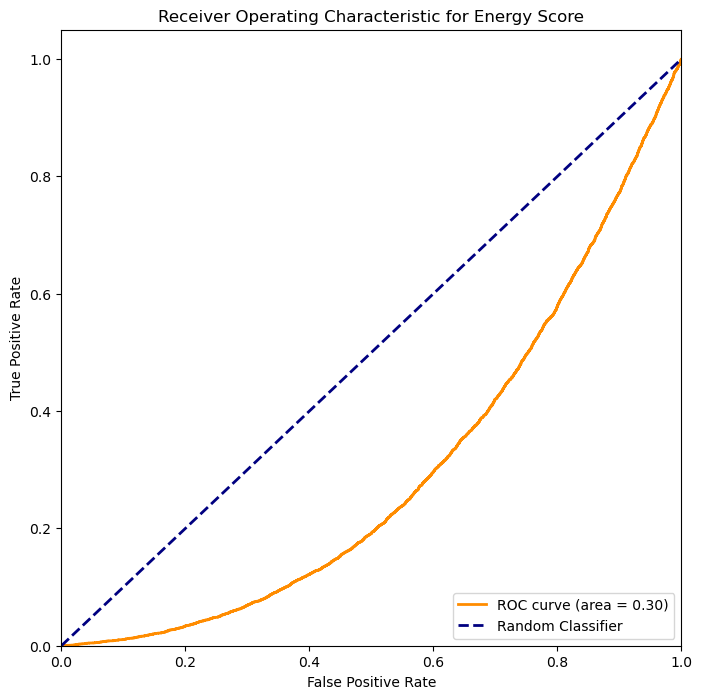


--- Evaluating Mahalanobis ---
AUROC: 0.6101
AUPR: 0.5656


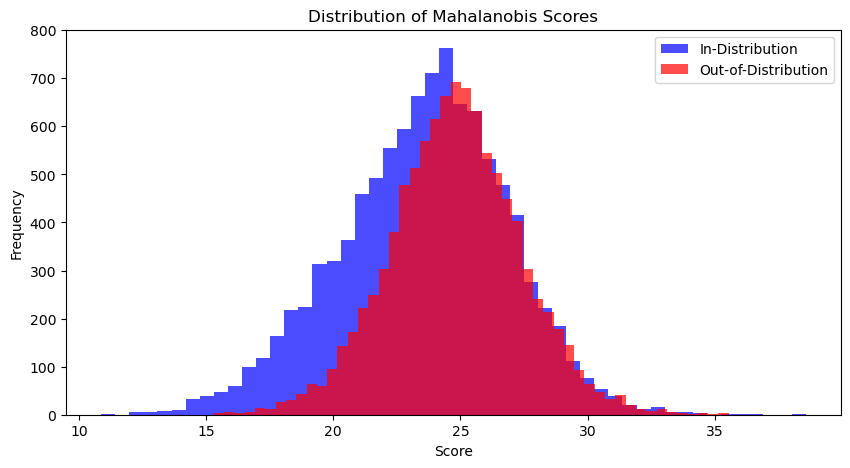

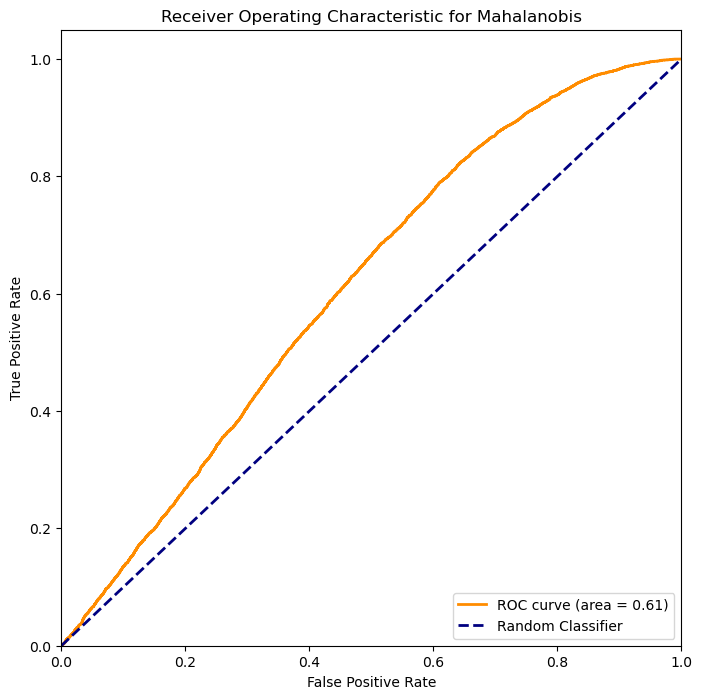


--- Evaluating ViM ---
AUROC: 0.4761
AUPR: 0.4632


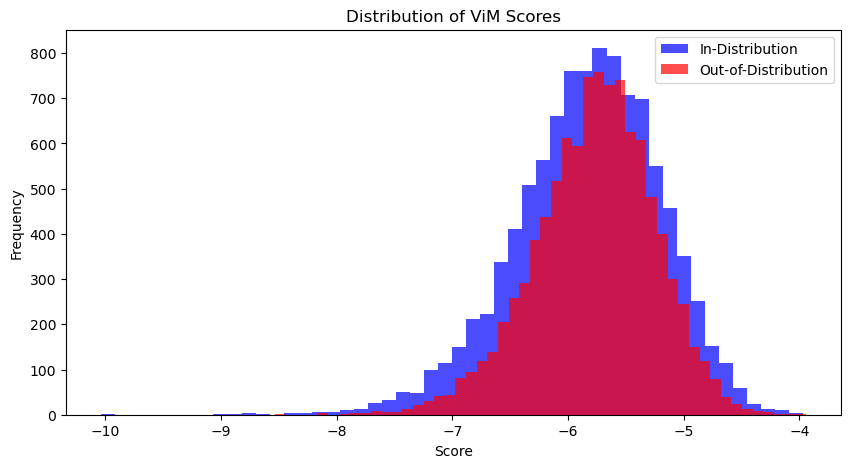

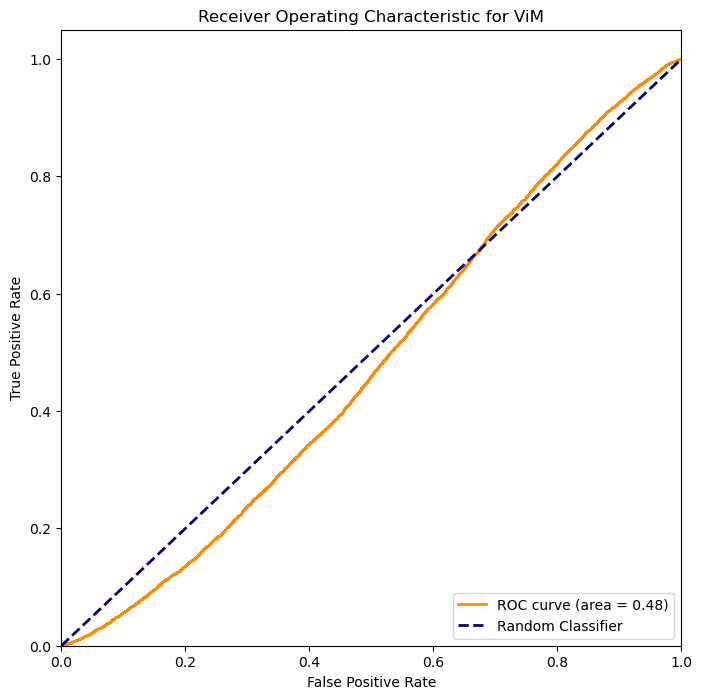

In [21]:
evaluate_ood_method(msp_id_scores, msp_ood_scores, "MSP")
evaluate_ood_method(max_logit_id_scores, max_logit_ood_scores, "Max Logit")
evaluate_ood_method(energy_id_scores, energy_ood_scores, "Energy Score")
evaluate_ood_method(mahalanobis_id_scores, mahalanobis_ood_scores, "Mahalanobis")
evaluate_ood_method(vim_id_scores, vim_ood_scores, "ViM")

## NC analysis for model 2

In [10]:
id_train_features_nc, id_train_logits_nc, id_train_labels_nc = extract_model_outputs(
    resnet18,
    cifar100_dataset.train_loader,
)

In [23]:
H_nc = id_train_features_nc
y_nc = id_train_labels_nc
classes_nc = torch.unique(y_nc).sort().values
N_nc, p_nc = H_nc.shape
C_nc = classes_nc.numel()

mu_G_nc = H_nc.mean(dim=0)
mu_c_nc = torch.stack([H_nc[y_nc == c].mean(dim=0) for c in classes_nc], dim=0)  # [C, p]
M_nc = mu_c_nc - mu_G_nc
Mdot_nc = M_nc.T

print(f"NC setup: N={N_nc}, p={p_nc}, C={C_nc}")
print(f"mu_c shape: {mu_c_nc.shape}, Mdot shape: {Mdot_nc.shape}")


NC setup: N=50000, p=512, C=100
mu_c shape: torch.Size([100, 512]), Mdot shape: torch.Size([512, 100])


In [24]:
# NC moments and NC1
Sigma_W_nc = torch.zeros(p_nc, p_nc, device=H_nc.device, dtype=H_nc.dtype)
for c in classes_nc:
    Hc = H_nc[y_nc == c]
    mc = Hc.mean(dim=0)
    Xc = Hc - mc
    Sigma_W_nc += (Xc.T @ Xc) / N_nc

Sigma_B_nc = (M_nc.T @ M_nc) / C_nc
X_nc = H_nc - mu_G_nc
Sigma_T_nc = (X_nc.T @ X_nc) / N_nc

decomp_rel_err_nc = torch.linalg.norm(Sigma_T_nc - Sigma_B_nc - Sigma_W_nc, ord='fro') / (
    torch.linalg.norm(Sigma_T_nc, ord='fro') + 1e-12
)

nc1_trace_ratio_new = (torch.trace(Sigma_W_nc) / (torch.trace(Sigma_B_nc) + 1e-12)).item()
nc1_fro_ratio_new = (torch.linalg.norm(Sigma_W_nc, ord='fro') / (torch.linalg.norm(Sigma_B_nc, ord='fro') + 1e-12)).item()

print(f"Decomposition relative error: {decomp_rel_err_nc.item():.3e}")
print(f"NC1 trace ratio tr(Sw)/tr(Sb): {nc1_trace_ratio_new:.6f}")
print(f"NC1 Fro ratio ||Sw||_F/||Sb||_F: {nc1_fro_ratio_new:.6f}")


Decomposition relative error: 4.028e-07
NC1 trace ratio tr(Sw)/tr(Sb): 0.541615
NC1 Fro ratio ||Sw||_F/||Sb||_F: 0.325954


In [25]:
# NC2 (Simplex ETF) and NC3 (self-duality)
centered_norms_nc = torch.linalg.norm(M_nc, dim=1)
U_nc = M_nc / (centered_norms_nc.unsqueeze(1) + 1e-12)
G_nc = U_nc @ U_nc.T

I_nc = torch.eye(C_nc, device=H_nc.device, dtype=H_nc.dtype)
ones_nc = torch.ones((C_nc, C_nc), device=H_nc.device, dtype=H_nc.dtype)
G_etf_nc = I_nc - (ones_nc - I_nc) / (C_nc - 1)

nc2_norm_cv_new = (centered_norms_nc.std() / (centered_norms_nc.mean() + 1e-12)).item()
nc2_etf_err_new = (
    torch.linalg.norm(G_nc - G_etf_nc, ord='fro')
    / (torch.linalg.norm(G_etf_nc, ord='fro') + 1e-12)
).item()

offdiag_nc = G_nc[~torch.eye(C_nc, dtype=torch.bool, device=G_nc.device)]
target_offdiag_nc = -1.0 / (C_nc - 1)

W_all_nc = resnet18.model.fc.weight.data.to(H_nc.device)  # [num_classes_model, p]
W_sel_nc = W_all_nc[classes_nc]                            # align model rows with dataset class ids
Wn_nc = W_sel_nc.T / (torch.linalg.norm(W_sel_nc.T, ord='fro') + 1e-12)
Mn_nc = Mdot_nc / (torch.linalg.norm(Mdot_nc, ord='fro') + 1e-12)
nc3_self_duality_new = torch.linalg.norm(Wn_nc - Mn_nc, ord='fro').item()

w_cos_nc = F.cosine_similarity(W_sel_nc, M_nc, dim=1)

print(f"NC2 norm CV: {nc2_norm_cv_new:.6f}")
print(f"NC2 ETF Gram relative error: {nc2_etf_err_new:.6f}")
print(f"NC2 offdiag cosine mean/std: {offdiag_nc.mean().item():.6f} / {offdiag_nc.std().item():.6f}")
print(f"NC2 target offdiag cosine: {target_offdiag_nc:.6f}")
print(f"NC3 self-duality ||W^T/||W||_F - Mdot/||Mdot||_F||_F: {nc3_self_duality_new:.6f}")
print(f"NC3 cos(weight_c, mu_c-mu_G) mean/min: {w_cos_nc.mean().item():.6f} / {w_cos_nc.min().item():.6f}")


NC2 norm CV: 0.056746
NC2 ETF Gram relative error: 0.839379
NC2 offdiag cosine mean/std: -0.010011 / 0.084790
NC2 target offdiag cosine: -0.010101
NC3 self-duality ||W^T/||W||_F - Mdot/||Mdot||_F||_F: 0.311760
NC3 cos(weight_c, mu_c-mu_G) mean/min: 0.956529 / 0.941392


In [26]:
# NC4: network decision vs nearest class center (NCC)
if 'id_train_logits_nc' in globals():
    logits_nc = id_train_logits_nc
else:
    # fallback: recompute logits from train loader
    _, logits_nc, _ = extract_model_outputs(resnet18, cifar100_dataset.train_loader)

net_pred_nc = logits_nc.argmax(dim=1)

h2_nc = (H_nc * H_nc).sum(dim=1, keepdim=True)
m2_nc = (mu_c_nc * mu_c_nc).sum(dim=1).unsqueeze(0)
d2_nc = h2_nc + m2_nc - 2.0 * (H_nc @ mu_c_nc.T)
ncc_idx_nc = d2_nc.argmin(dim=1)
ncc_pred_nc = classes_nc[ncc_idx_nc]

nc4_agreement_new = (net_pred_nc == ncc_pred_nc).float().mean().item()
net_acc_new = (net_pred_nc == y_nc).float().mean().item()
ncc_acc_new = (ncc_pred_nc == y_nc).float().mean().item()

print(f"NC4 agreement P(network == NCC): {nc4_agreement_new:.6f}")
print(f"Train accuracy (network): {net_acc_new:.6f}")
print(f"Train accuracy (NCC): {ncc_acc_new:.6f}")


NC4 agreement P(network == NCC): 0.999840
Train accuracy (network): 0.999680
Train accuracy (NCC): 0.999720


## NC 5

In [44]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score


def extract_penultimate_features_v2(model, dataloader, device='cuda'):
    """
    Extract penultimate features by hooking the input to the final FC layer.
    Works for ResNet-like models with `model.fc`.
    Returns: features [N, p], logits [N, C], labels [N]
    """
    model.eval()

    if not hasattr(model, 'fc') or not isinstance(model.fc, nn.Module):
        raise ValueError("extract_penultimate_features_v2 expects model.fc to exist.")

    all_feats = []
    all_logits = []
    all_labels = []
    batch_feat = None

    def hook_fn(module, inputs, output):
        nonlocal batch_feat
        batch_feat = inputs[0].detach()

    handle = model.fc.register_forward_hook(hook_fn)
    try:
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs = inputs.to(device)
                logits = model(inputs)
                if batch_feat is None:
                    raise RuntimeError("Hook did not capture penultimate features.")

                all_feats.append(batch_feat.cpu().numpy())
                all_logits.append(logits.detach().cpu().numpy())
                all_labels.append(targets.cpu().numpy())
    finally:
        handle.remove()

    return np.vstack(all_feats), np.vstack(all_logits), np.concatenate(all_labels)


In [45]:
def compute_class_means_v2(features, labels):
    """
    Compute class means over classes present in labels.
    Returns:
      classes_sorted: [C_present]
      class_means: [C_present, p]
    """
    classes_sorted = np.sort(np.unique(labels))
    class_means = []

    for c in classes_sorted:
        mask = labels == c
        if not np.any(mask):
            continue
        class_means.append(features[mask].mean(axis=0))

    if len(class_means) < 2:
        raise ValueError("Need at least 2 classes to build NECO subspace.")

    return classes_sorted, np.vstack(class_means)


def compute_etf_subspace_v2(class_means, max_rank=None, svd_tol=1e-8):
    """
    Build feature-space basis of centered class means via SVD.
    """
    centered_means = class_means - class_means.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(centered_means, full_matrices=False)

    rank = int((S > svd_tol).sum())
    if max_rank is not None:
        rank = min(rank, max_rank)
    if rank < 1:
        raise ValueError("Computed ETF subspace has rank 0.")

    basis = Vt[:rank].T  # [p, rank]
    return basis


def neco_score_v2(features, etf_subspace, feature_mean):
    """
    NECO score = ||P_S (x - mu)|| / ||x - mu||
    where S is the ETF subspace and mu is fit-time feature mean.
    """
    centered = features - feature_mean[None, :]
    projected = centered @ etf_subspace

    subspace_norm = np.linalg.norm(projected, axis=1)
    total_norm = np.linalg.norm(centered, axis=1)
    return subspace_norm / (total_norm + 1e-8)


In [46]:
class NECODetectorV2:
    def __init__(self, model, device='cuda', threshold_percentile=5.0):
        self.model = model
        self.device = device
        self.threshold_percentile = threshold_percentile

        self.feature_mean = None
        self.classes_seen = None
        self.etf_subspace = None
        self.threshold = None

    def fit(self, id_dataloader):
        features, logits, labels = extract_penultimate_features_v2(
            self.model, id_dataloader, self.device
        )

        self.feature_mean = features.mean(axis=0)
        self.classes_seen, class_means = compute_class_means_v2(features, labels)
        self.etf_subspace = compute_etf_subspace_v2(
            class_means,
            max_rank=max(1, len(self.classes_seen) - 1),
        )

        id_scores = self.score_samples(features)
        self.threshold = np.percentile(id_scores, self.threshold_percentile)
        return self

    def score_samples(self, features):
        if self.etf_subspace is None or self.feature_mean is None:
            raise ValueError("NECODetectorV2 is not fitted. Call fit() first.")
        return neco_score_v2(features, self.etf_subspace, self.feature_mean)

    def predict(self, features):
        scores = self.score_samples(features)
        return (scores < self.threshold).astype(int)

    def predict_proba(self, features):
        return self.score_samples(features)


In [47]:
# Fit NECO v2 on CIFAR-100 train set
detector_v2 = NECODetectorV2(
    model=resnet18.model,
    device=resnet18.device,
    threshold_percentile=5.0,
)
detector_v2.fit(cifar100_dataset.train_loader)

print(f"NECO v2 fitted.")
print(f"Classes seen: {len(detector_v2.classes_seen)}")
print(f"ETF subspace shape: {detector_v2.etf_subspace.shape}")
print(f"Threshold (p5 ID score): {detector_v2.threshold:.6f}")


NECO v2 fitted.
Classes seen: 100
ETF subspace shape: (512, 99)
Threshold (p5 ID score): 0.906546


In [48]:
# Evaluate NECO v2 on ID(CIFAR-100 test) vs OOD(CIFAR-10 test)
id_test_features_v2, _, _ = extract_penultimate_features_v2(
    resnet18.model,
    cifar100_dataset.test_loader,
    resnet18.device,
)
ood_test_features_v2, _, _ = extract_penultimate_features_v2(
    resnet18.model,
    cifar10_dataset.test_loader,
    resnet18.device,
)

id_scores_v2 = detector_v2.predict_proba(id_test_features_v2)
ood_scores_v2 = detector_v2.predict_proba(ood_test_features_v2)
all_scores_v2 = np.concatenate([id_scores_v2, ood_scores_v2])
true_labels_v2 = np.concatenate([
    np.zeros(len(id_scores_v2), dtype=int),
    np.ones(len(ood_scores_v2), dtype=int),
])
pred_v2 = detector_v2.predict(np.concatenate([id_test_features_v2, ood_test_features_v2], axis=0))

fpr_v2, tpr_v2, _ = roc_curve(true_labels_v2, -all_scores_v2)
idx95_v2 = np.argmin(np.abs(tpr_v2 - 0.95))
fpr95_v2 = fpr_v2[idx95_v2]
auroc_v2 = roc_auc_score(true_labels_v2, -all_scores_v2)
aupr_v2 = average_precision_score(true_labels_v2, -all_scores_v2)
acc_v2 = (pred_v2 == true_labels_v2).mean()

print(f"NECO v2 FPR@95: {fpr95_v2:.4f}")
print(f"NECO v2 AUROC : {auroc_v2:.4f}")
print(f"NECO v2 AUPR  : {aupr_v2:.4f}")
print(f"NECO v2 Acc(threshold): {acc_v2:.4f}")


NECO v2 FPR@95: 0.7907
NECO v2 AUROC : 0.6693
NECO v2 AUPR  : 0.6226
NECO v2 Acc(threshold): 0.6106


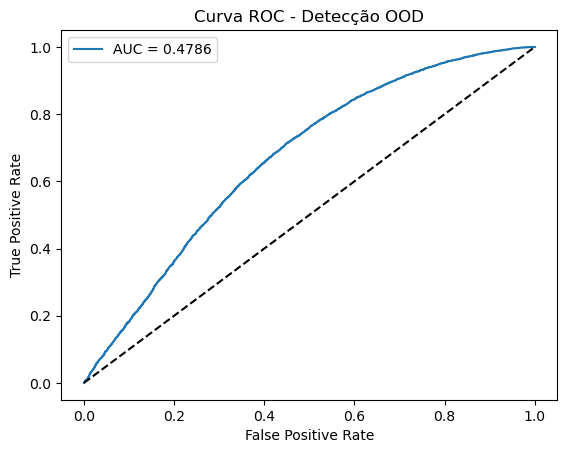

In [50]:

# Plot ROC curve
plt.figure()
plt.plot(fpr_v2, tpr_v2, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Detecção OOD')
plt.legend()
plt.show()

NECO v2 FPR@95: 0.7907
NECO v2 AUROC : 0.6693
NECO v2 AUPR  : 0.6226
NECO v2 Acc(threshold): 0.6106


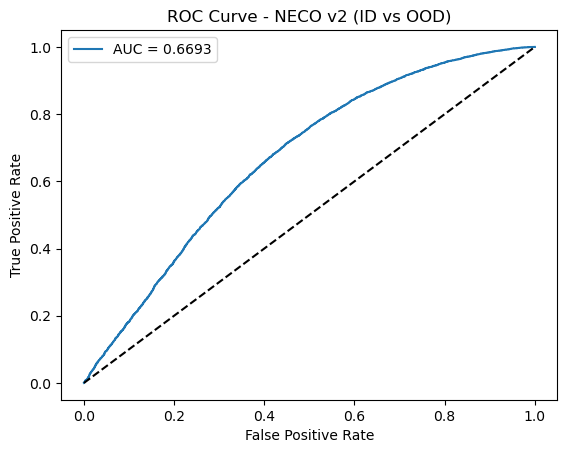

/tmp/ipykernel_47248/1983400666.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot_v2, labels=['ID', 'OOD'])


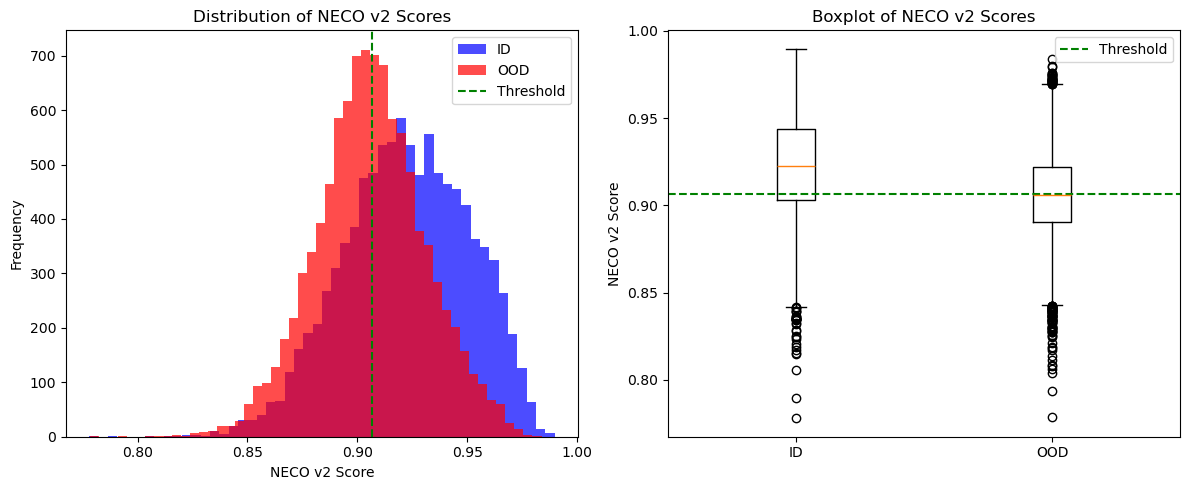

In [55]:
# Evaluate NECO v2 on ID(CIFAR-100 test) vs OOD(CIFAR-10 test)
id_test_features_v2, _, _ = extract_penultimate_features_v2(
    resnet18.model,
    cifar100_dataset.test_loader,
    resnet18.device,
)
ood_test_features_v2, _, _ = extract_penultimate_features_v2(
    resnet18.model,
    cifar10_dataset.test_loader,
    resnet18.device,
)

id_scores_v2 = detector_v2.predict_proba(id_test_features_v2)
ood_scores_v2 = detector_v2.predict_proba(ood_test_features_v2)
all_scores_v2 = np.concatenate([id_scores_v2, ood_scores_v2])
true_labels_v2 = np.concatenate([
    np.zeros(len(id_scores_v2), dtype=int),
    np.ones(len(ood_scores_v2), dtype=int),
])
pred_v2 = detector_v2.predict(np.concatenate([id_test_features_v2, ood_test_features_v2], axis=0))

fpr_v2, tpr_v2, _ = roc_curve(true_labels_v2, -all_scores_v2)
idx95_v2 = np.argmin(np.abs(tpr_v2 - 0.95))
fpr95_v2 = fpr_v2[idx95_v2]
auroc_v2 = roc_auc_score(true_labels_v2, -all_scores_v2)
aupr_v2 = average_precision_score(true_labels_v2, -all_scores_v2)
acc_v2 = (pred_v2 == true_labels_v2).mean()

print(f"NECO v2 FPR@95: {fpr95_v2:.4f}")
print(f"NECO v2 AUROC : {auroc_v2:.4f}")
print(f"NECO v2 AUPR  : {aupr_v2:.4f}")
print(f"NECO v2 Acc(threshold): {acc_v2:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr_v2, tpr_v2, label=f'AUC = {auroc_v2:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - NECO v2 (ID vs OOD)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))

# Histograms of scores
plt.subplot(1, 2, 1)
plt.hist(id_scores_v2, bins=50, alpha=0.7, label='ID', color='blue')
plt.hist(ood_scores_v2, bins=50, alpha=0.7, label='OOD', color='red')
plt.axvline(x=detector_v2.threshold, color='green', linestyle='--', label='Threshold')
plt.xlabel('NECO v2 Score')
plt.ylabel('Frequency')
plt.title('Distribution of NECO v2 Scores')
plt.legend()

# Boxplot
plt.subplot(1, 2, 2)
data_to_plot_v2 = [id_scores_v2, ood_scores_v2]
plt.boxplot(data_to_plot_v2, labels=['ID', 'OOD'])
plt.axhline(y=detector_v2.threshold, color='green', linestyle='--', label='Threshold')
plt.ylabel('NECO v2 Score')
plt.title('Boxplot of NECO v2 Scores')
plt.legend()

plt.tight_layout()
plt.show()
